# Background

_taken from [Fraud Detection in Electricity and Gas Consumption](https://www.kaggle.com/datasets/mrmorj/fraud-detection-in-electricity-and-gas-consumption)._

The data provided by STEG is composed of two files. The first one is comprised of client data and the second one contains billing history from 2005 to 2019.

There are 2 .zip files for download, train.zip, and test.zip and a SampleSubmission.csv. In each .zip file you will find a client and invoice file.

Variable definitions

Client:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0
<br />
<br />


Invoice data

- Client_id: Unique id for the client
- Invoice_date: Date of the invoice
- Tarif_type: Type of tax
- Counter_number:
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Old_index: Old index
- New_index: New index
- Months_number: Month number
- Counter_type: Type of counter

# Phase 1: Business and Data Understanding

### Business Understanding
- Determine business objectives
- Assess situation
- Determine data mining and machine learning goals

### Data Understanding: descriptive statistics
- Explore Y
- Define Y with results exploration
- Assess missing values
- Assess data structure
- Explore correlation plot (X, Y)

## Business Understanding

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model
import seaborn as sns

# supressing warnings for readability
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
# plt.style.use("seaborn-whitegrid")

# setting up plot style 
plt.style.use('seaborn-poster')
plt.style.use('fivethirtyeight')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc("axes", labelsize=14, titlesize=14)
mpl.rc("figure", titlesize=20)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# contants for figsize
S = (5, 5)
M = (8, 8)
L = (12, 12)

In [2]:
# import data
df_client = pd.read_csv('../data/external/train/client_train.csv')
df_invoice = pd.read_csv('../data/external/train/invoice_train.csv')

In [4]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [5]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


## Client Dataset

In [10]:
df_client.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [27]:
df_client.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [12]:
df_client.client_catg.unique()
# Client categories are not clear.
# Need more information about this.

array([11, 12, 51], dtype=int64)

In [18]:
print('Unique distric:', df_client.disrict.nunique())
df_client.disrict.unique()
# This also a bit unclear.
# Data has only 4 district, need verification.

Unique distric: 4


array([60, 69, 62, 63], dtype=int64)

In [20]:
print('Unique region:', df_client.region.nunique())
df_client.region.unique()

Unique region: 25


array([101, 107, 301, 105, 303, 103, 309, 311, 304, 104, 312, 305, 306,
       308, 372, 307, 313, 310, 371, 302, 106, 379, 399, 206, 199],
      dtype=int64)

In [25]:
df_client.creation_date

'01/01/1997'

In [29]:
pd.to_datetime(df_client.creation_date).describe()
# It is say that some data has been created
# as early as 1977, which is a bit suspicious
# Maybe consider to remove data below 2000

count                           135493
mean     2002-10-01 18:45:16.001564544
min                1977-02-05 00:00:00
25%                1994-01-12 00:00:00
50%                2005-09-19 00:00:00
75%                2012-04-04 00:00:00
max                2019-09-10 00:00:00
Name: creation_date, dtype: object

## Let's try some visualization and correlation

In [3]:
dfc = df_client.copy()

In [104]:
# function for plotting repetitive countplots in univariate categorical analysis on applicationDF
# This function will create two subplots: 
# 1. Count plot of categorical column w.r.t target; 
# 2. Percentage of Fraud within column

def univariate_categorical(feature,df=dfc,target='target',ylog=False,label_rotation=False,horizontal_layout=True):
    temp = df[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, target]].groupby([feature],as_index=False).mean()
    cat_perc[target] = cat_perc[target]*100
    cat_perc.sort_values(by=target, ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,24))
        
    # 1. Subplot 1: Count plot of categorical column
    # sns.set_palette("Set2")
    s = sns.countplot(ax=ax1, 
                    x = feature, 
                    data=df,
                    hue =target,
                    order=cat_perc[feature],
                    palette=['g','r'])
    
    # Define common styling
    ax1.set_title(feature, fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'}) 
    ax1.legend(['Not fraud','Fraud'])
    
    # If the plot is not readable, use the log scale.
    if ylog:
        ax1.set_yscale('log')
        ax1.set_ylabel("Count (log)",fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'})   
    
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    # 2. Subplot 2: Percentage of Fraud within the categorical column
    s = sns.barplot(ax=ax2, 
                    x = feature, 
                    y=target, 
                    order=cat_perc[feature], 
                    data=cat_perc,
                    palette='Set2')
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of Fraud [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    ax2.set_title(feature + " Fraud %", fontdict={'fontsize' : 15, 'fontweight' : 5, 'color' : 'Blue'}) 

    plt.show()

In [61]:
# function for plotting repetitive countplots in bivariate categorical analysis

def bivariate_bar(x,y,df,hue,figsize):
    
    plt.figure(figsize=figsize)
    sns.barplot(x=x,
                  y=y,
                  data=df, 
                  hue=hue, 
                #   order=df[y], 
                  palette =['g','r'])     
        
    # Defining aesthetics of Labels and Title of the plot using style dictionaries
    plt.xlabel(x,fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'})    
    plt.ylabel(y,fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'})    
    # plt.title(col, fontdict={'fontsize' : 15, 'fontweight' : 5, 'color' : 'Blue'}) 
    plt.xticks(rotation=90, ha='right')
    plt.legend(labels = ['Not fraud','Fraud'])
    plt.show()

In [62]:
# function for plotting repetitive rel plots in bivaritae numerical analysis on applicationDF

def bivariate_rel(x,y,df,kind,figsize,target='target'):
    
    plt.figure(figsize=figsize)
    sns.relplot(x=x, 
                y=y, 
                data=df, 
                hue=target,
                kind=kind,
                palette = ['g','r'],
                legend='auto'
                )
    plt.legend(['Not fraud','Fraud'])
    plt.xticks(rotation=90, ha='right')
    plt.show()

In [63]:
def visualize_categorical_datetime(df, categorical_column, datetime_column):
    """
    Function to visualize the relationship between a categorical column and a datetime column.

    Parameters:
        - data (DataFrame): The input DataFrame containing the categorical and datetime columns.
        - categorical_column (str): The name of the categorical column.
        - datetime_column (str): The name of the datetime column.
    """

    # Set up the figure and axes for subplots
    data = df.copy()
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Convert the datetime column to datetime type if it's not already
    data[datetime_column] = pd.to_datetime(data[datetime_column])

    # Extract the year from the datetime column
    data['Year'] = data[datetime_column].dt.year

    # Calculate the percentage of True values and number of transactions for each year
    df_agg = data.groupby('Year').agg({categorical_column: ['mean', 'count']})

    # Calculate the percentage of True values for each year
    df_percentage = df_agg[categorical_column]['mean'] * 100

    # Create the subplot for the percentage of True values
    axs[0].plot(df_percentage.index, df_percentage, marker='o', color='blue')
    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('Percentage of True Values')
    axs[0].set_title('Percentage of True Values for Each Year')

    # Create the subplot for the number of transactions
    axs[1].plot(df_agg.index, df_agg[categorical_column]['count'], marker='o', color='green')
    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('Number of Transactions')
    axs[1].set_title('Number of Transactions for Each Year')

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.4)

    # Show the plot
    plt.show()

In [64]:
#function for plotting repetitive countplots in univariate categorical analysis on the merged df

def univariate_merged(col,df,hue,palette,ylog,figsize):
    plt.figure(figsize=figsize)
    ax=sns.countplot(x=col, 
                  data=df,
                  hue= hue,
                  palette= palette,
                  order=df[col].value_counts().index)
    

    if ylog:
        plt.yscale('log')
        plt.ylabel("Count (log)",fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'})     
    else:
        plt.ylabel("Count",fontdict={'fontsize' : 10, 'fontweight' : 3, 'color' : 'Blue'})       

    plt.title(col , fontdict={'fontsize' : 15, 'fontweight' : 5, 'color' : 'Blue'}) 
    plt.legend(loc = "upper right")
    plt.xticks(rotation=90, ha='right')
    
    plt.show()

In [65]:
# Function to plot point plots on merged dataframe

def merged_pointplot(x,y, df, target='target'):
    plt.figure(figsize=(8,4))
    sns.pointplot(x=x, 
                  y=y, 
                  hue=target, 
                  data=df,
                  palette =['g','r'])
   # plt.legend(['Repayer','Defaulter'])

In [249]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [250]:
cat_cols = ['disrict', 'client_catg', 'region']
dt_cols = ['creation_date']
bool_cols = ['target']

def convert_dtype(df):
    convert_dict = {}
    for col in cat_cols:
        convert_dict[col] = 'category'
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime)
    for col in bool_cols:
        convert_dict[col] = 'bool'
    return df.astype(convert_dict)

dfc = convert_dtype(dfc)

In [251]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   disrict        135493 non-null  category      
 1   client_id      135493 non-null  object        
 2   client_catg    135493 non-null  category      
 3   region         135493 non-null  category      
 4   creation_date  135493 non-null  datetime64[ns]
 5   target         135493 non-null  bool          
dtypes: bool(1), category(3), datetime64[ns](1), object(1)
memory usage: 2.6+ MB


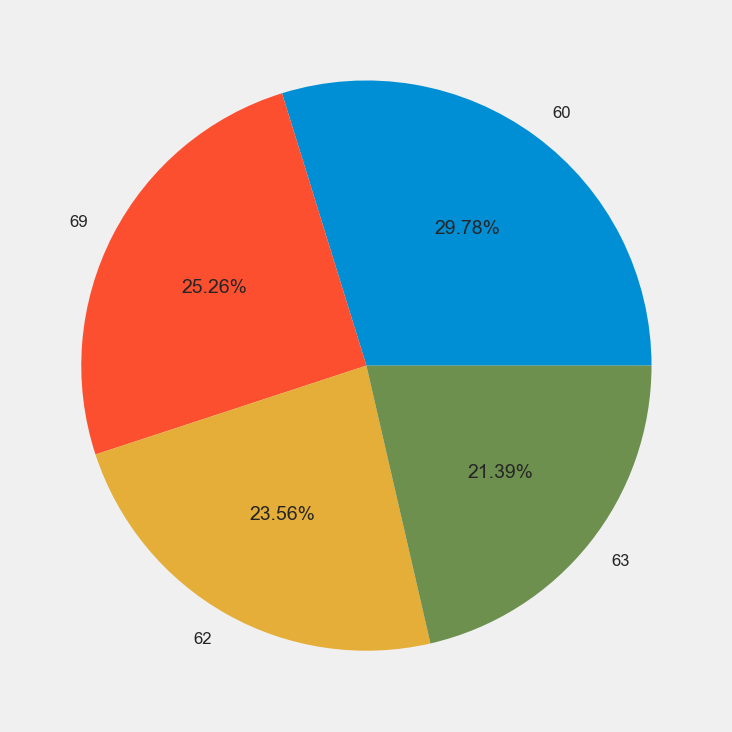

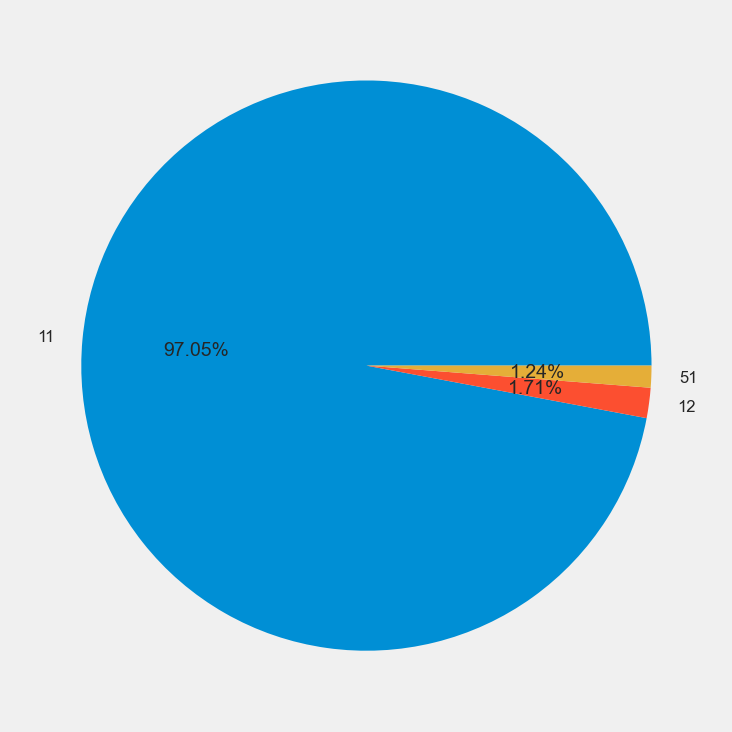

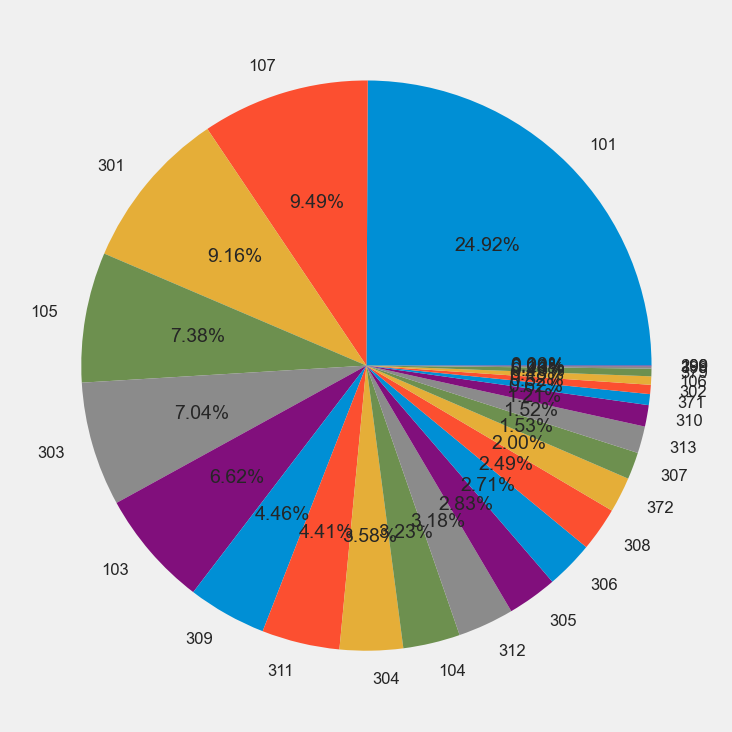

In [252]:
for col in cat_cols:
    plt.pie(dfc[col].value_counts(), labels=dfc[col].unique(), autopct='%1.2f%%')
    plt.show()

<Axes: xlabel='target'>

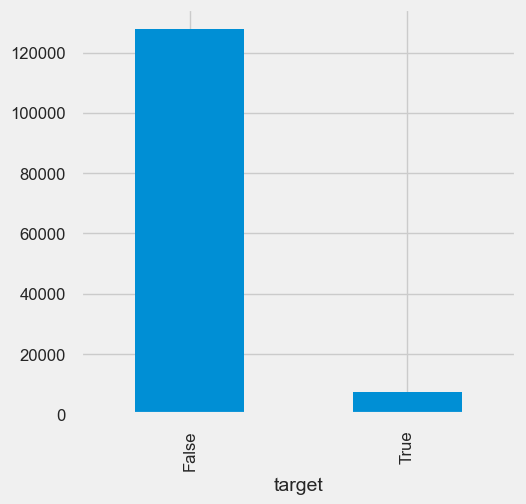

In [253]:
dfc['target'].value_counts().plot(kind='bar', figsize=S)
# Heavily imbalance

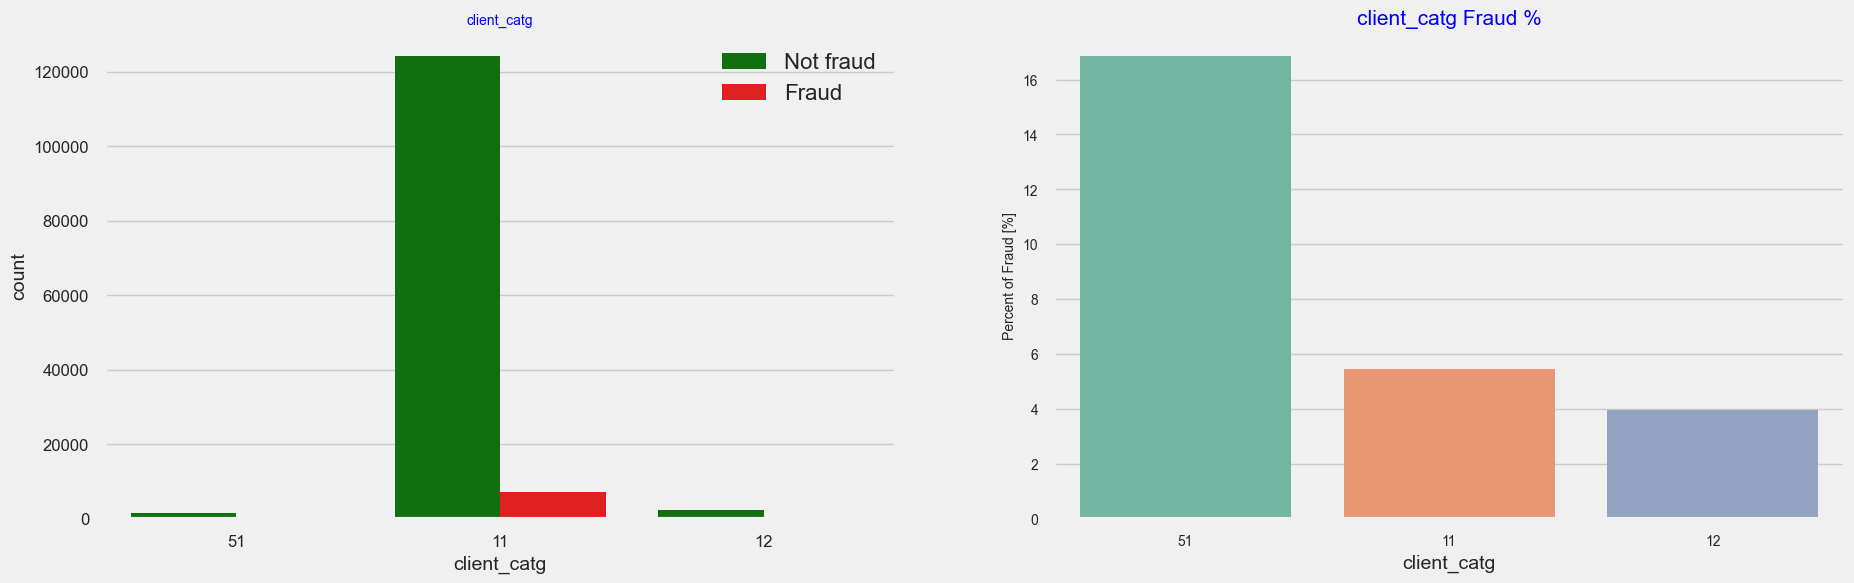

In [254]:
univariate_categorical('client_catg')

### Inferences:
- Majority of client are from client_catg 11
- Most fraud (by percentage) are from client_catg 51
- Based on data, client_catg 51 is **not safe**, and client_catg 12 is probably the most safe

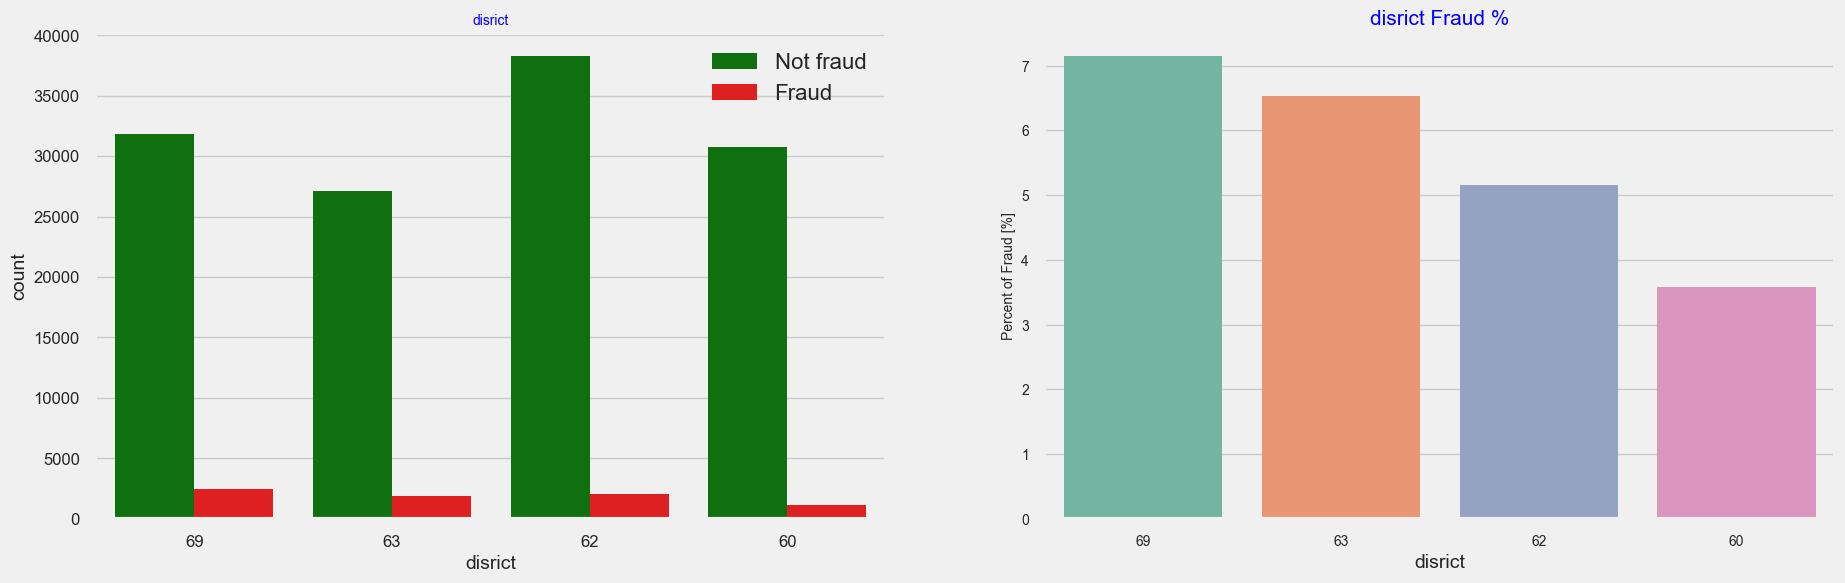

In [255]:
univariate_categorical('disrict')

### Inferences:
- Although we could assume that district 68 and 63 is not that safe, but due to insignificant difference between the others, we cannot conclude that.

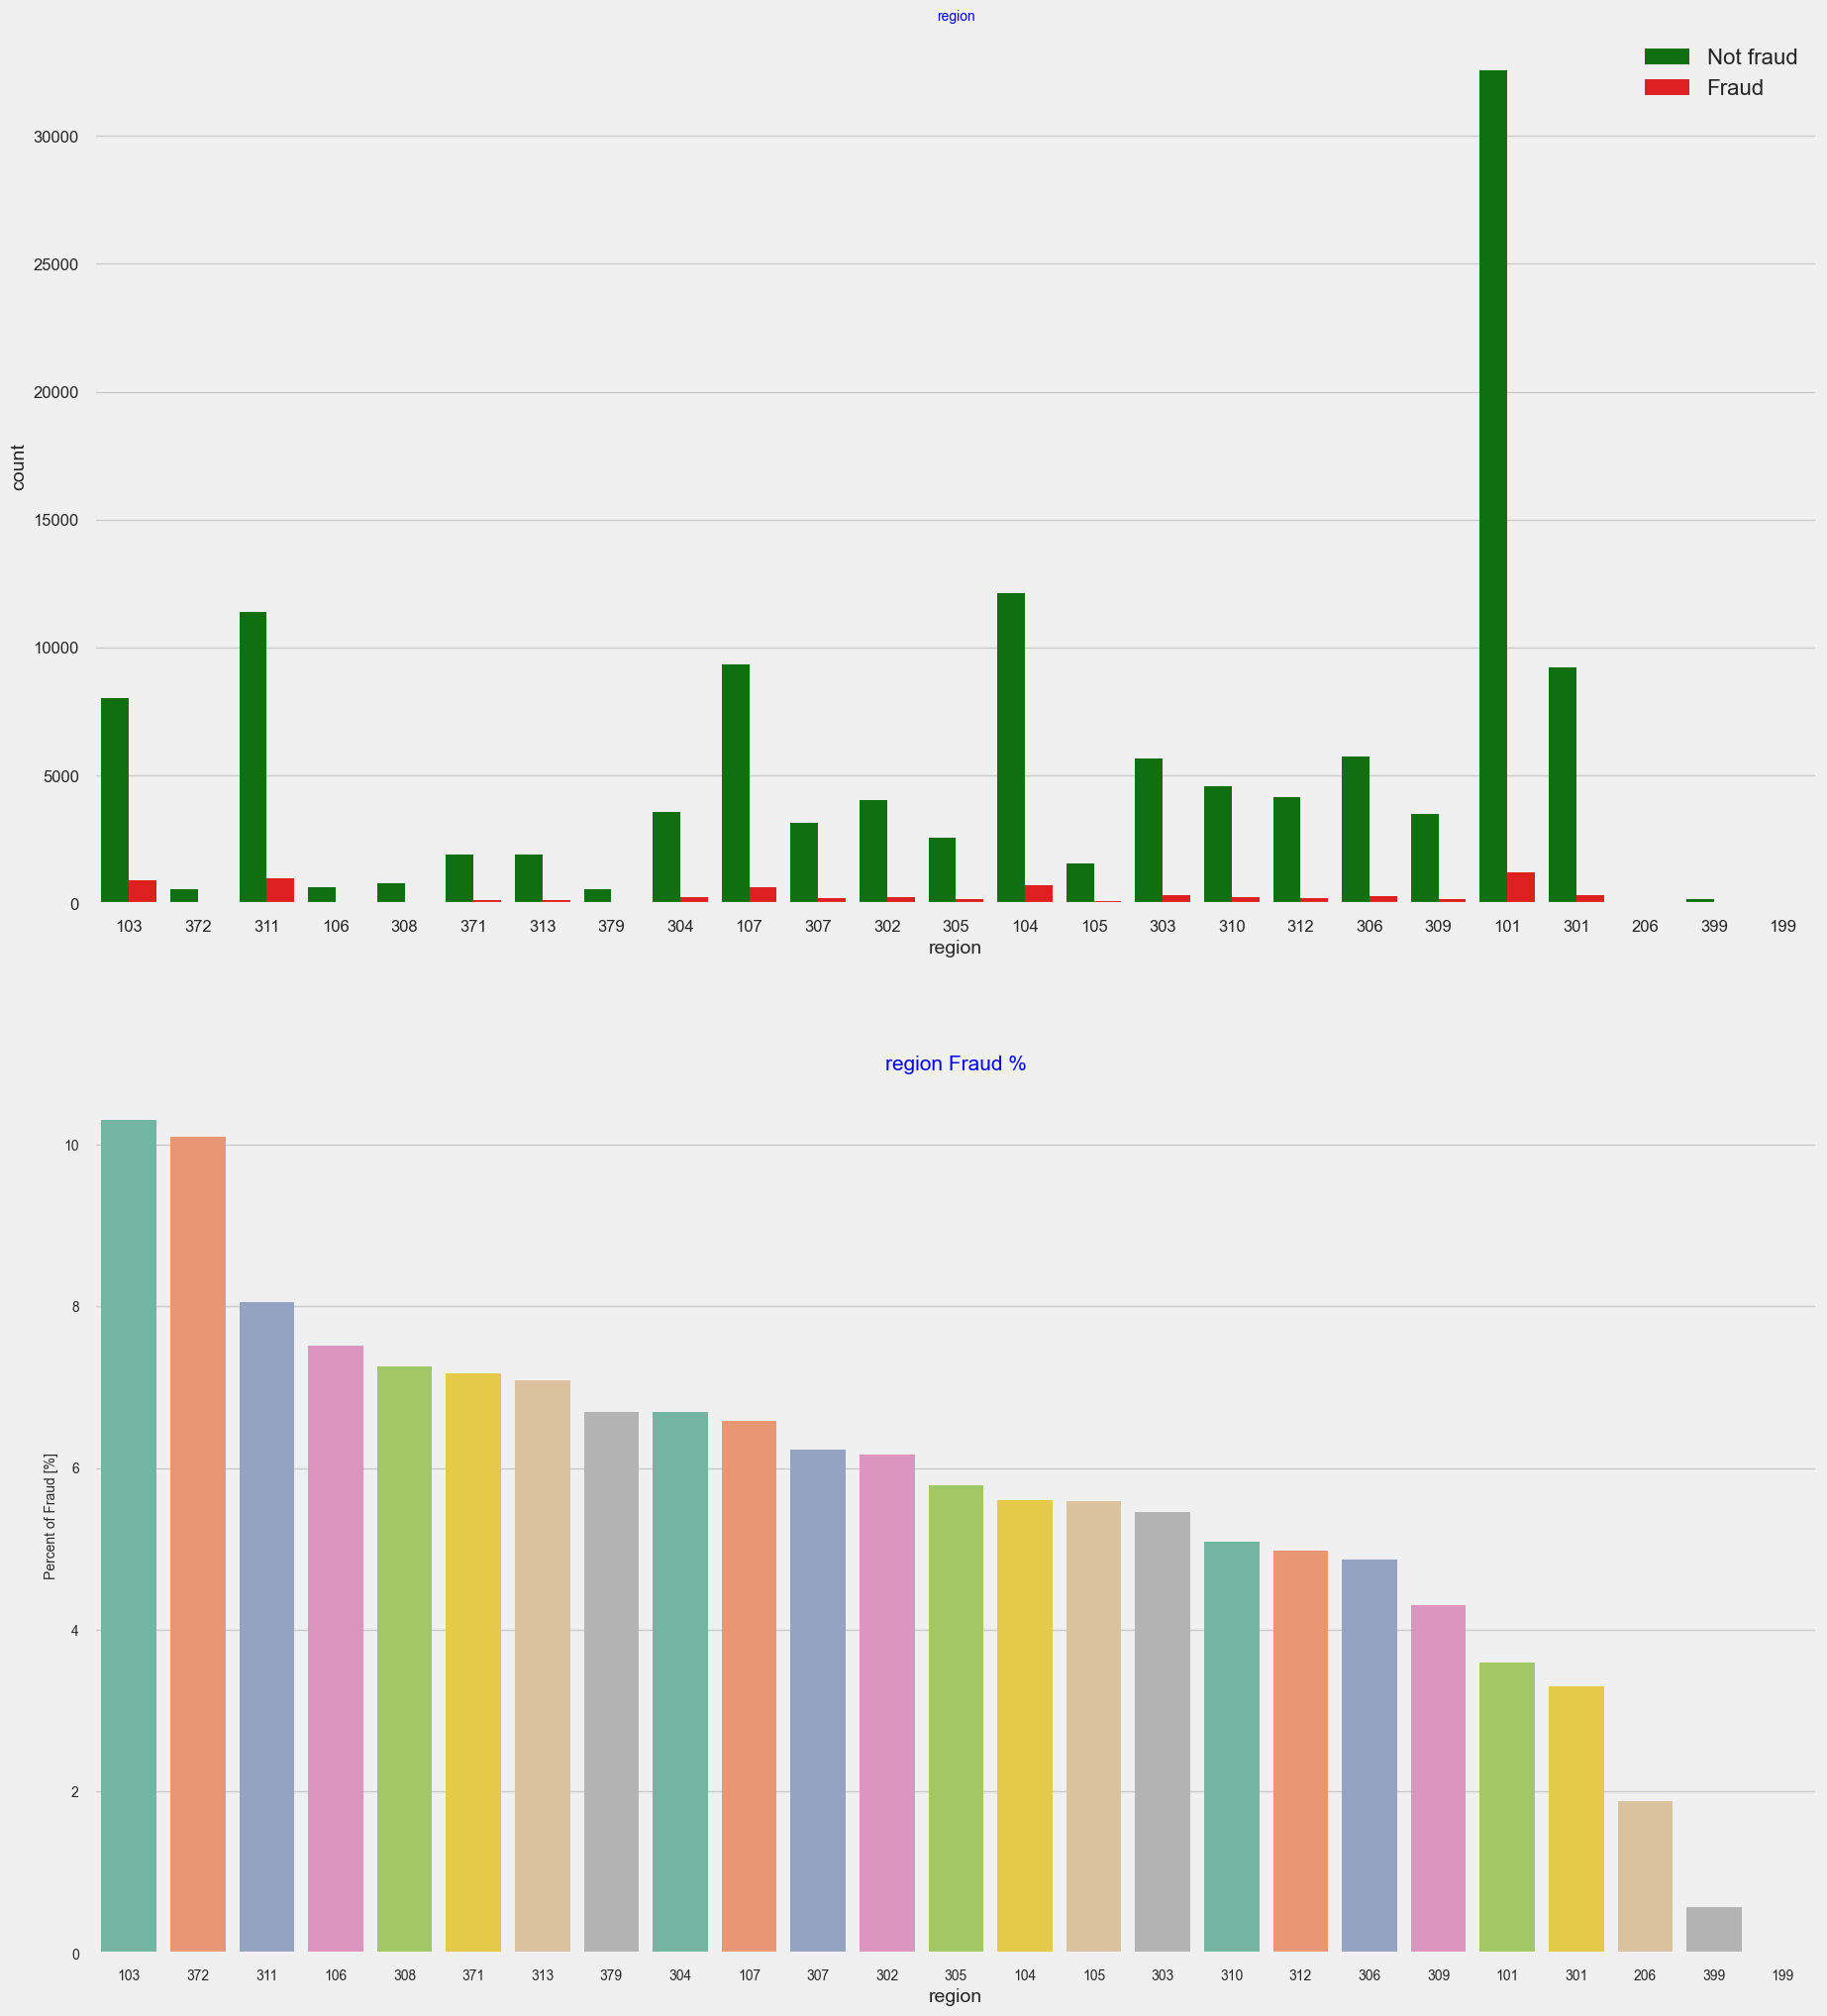

In [256]:
univariate_categorical('region', horizontal_layout=False)

In [257]:
dfc.groupby('region')['client_id'].count().sort_values(ascending=True).head(7)

region
199      2
206     53
399    175
379    583
372    644
106    706
308    841
Name: client_id, dtype: int64

### Inferences:
- The majority of clients are from region 101, and surprisingly have a relatively low fraud percentage
- Based on data, region 103, 372, 311 are **not safe** from fraud, achieving more than 10% case of fraud.
- Region 101 and 301 are **safe**, considering they have a low percentage of fraud with high transactions.
- Region 199, 399, and 206 are safe, but they also have only some record of transactions, not as many as the others.

In [258]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   disrict        135493 non-null  category      
 1   client_id      135493 non-null  object        
 2   client_catg    135493 non-null  category      
 3   region         135493 non-null  category      
 4   creation_date  135493 non-null  datetime64[ns]
 5   target         135493 non-null  bool          
dtypes: bool(1), category(3), datetime64[ns](1), object(1)
memory usage: 2.6+ MB


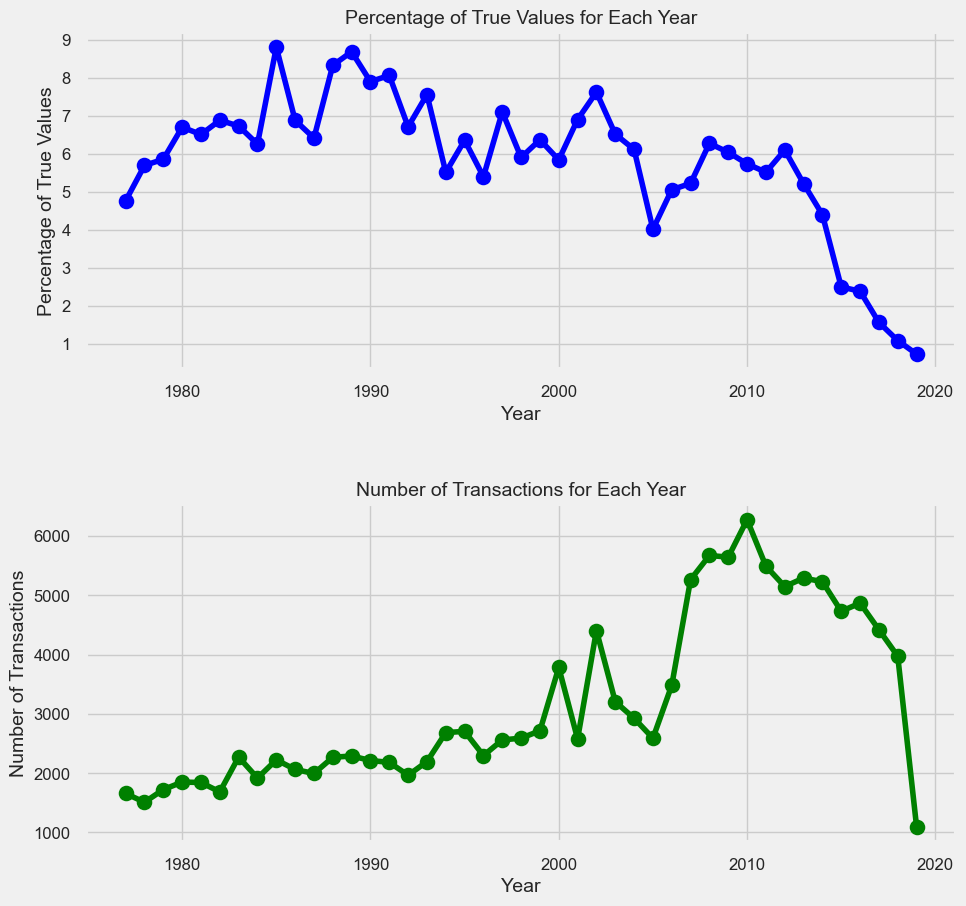

In [259]:
visualize_categorical_datetime(dfc, 'target', 'creation_date')

### Inferences
- Year 2010 have the most transaction
- After 2012, fraud case seems to decrease

In [260]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   disrict        135493 non-null  category      
 1   client_id      135493 non-null  object        
 2   client_catg    135493 non-null  category      
 3   region         135493 non-null  category      
 4   creation_date  135493 non-null  datetime64[ns]
 5   target         135493 non-null  bool          
dtypes: bool(1), category(3), datetime64[ns](1), object(1)
memory usage: 2.6+ MB


In [268]:
import pandas as pd
import numpy as np
import scipy.stats as stats

def create_correlation_table(df, categorical_columns, target_column, datetime_column):
    # Convert categorical columns to numeric representation
    df_numeric = df.copy()
    for column in categorical_columns:
        df_numeric[column] = pd.Categorical(df[column]).codes

    # Calculate the Cramér's V statistic for categorical variables
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = stats.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        rcorr = r - ((r - 1) ** 2) / (n - 1)
        kcorr = k - ((k - 1) ** 2) / (n - 1)
        return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

    correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
    for i in range(len(categorical_columns)):
        for j in range(i, len(categorical_columns)):
            x = df_numeric[categorical_columns[i]]
            y = df_numeric[categorical_columns[j]]
            correlation = cramers_v(x, y)
            correlation_matrix.loc[categorical_columns[i], categorical_columns[j]] = correlation
            correlation_matrix.loc[categorical_columns[j], categorical_columns[i]] = correlation

    # Calculate the point-biserial correlation coefficient for the target column
    point_biserial_correlation = {}
    for column in categorical_columns:
        x = df[column]
        y = df[target_column]
        correlation, _ = stats.pointbiserialr(x, y)
        point_biserial_correlation[column] = correlation
    point_biserial_correlation_series = pd.Series(point_biserial_correlation, name=target_column)

    # Convert datetime column to numeric representation
    df_numeric[datetime_column] = pd.to_numeric(df[datetime_column])

    # Calculate the Pearson correlation coefficient for the datetime column
    datetime_correlation = {}
    for column in categorical_columns:
        x = df_numeric[datetime_column]
        y = df[column]
        correlation, _ = stats.pearsonr(x, y)
        datetime_correlation[column] = correlation
    datetime_correlation_series = pd.Series(datetime_correlation, name=datetime_column)

    # Calculate the point-biserial correlation coefficient between target and datetime columns
    dt_target_correlation = {}
    x = df_numeric[datetime_column]
    y = df[target_column]
    correlation, _ = stats.pointbiserialr(x, y)
    dt_target_correlation[target_column] = correlation
    dt_target_correlation_series = pd.Series(dt_target_correlation, name=datetime_column)

    # Combine all correlation coefficients into a single correlation table
    correlation_table = pd.concat([correlation_matrix, point_biserial_correlation_series, datetime_correlation_series, dt_target_correlation_series],
                                  axis=1)

    return correlation_table


create_correlation_table(dfc, cat_cols, 'target', 'creation_date')

,disrict,client_catg,region,target,creation_date,creation_date
disrict,1.0,0.03622,0.980419,0.050749,0.137422,NaN
client_catg,0.03622,1.0,0.055906,0.054745,0.053898,NaN
region,0.980419,0.055906,1.0,0.010940,-0.005332,NaN
target,NaN,NaN,NaN,NaN,NaN,-0.05224


### Inferences:
Based on the correlation table, there is no variable that correlate strongly to target

## Dataset Invoice

In [351]:
dfc = df_invoice.copy()

In [352]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [353]:
dfc.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [354]:
dfc['months_number'].describe()
# Also suspicius, having outliers and probably skewed since 4 appears in 1st, 2nd, and 3rd quartiles.

count   4476749.000
mean         44.831
std        3128.335
min           0.000
25%           4.000
50%           4.000
75%           4.000
max      636624.000
Name: months_number, dtype: float64

In [355]:
conso_cols = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']
dfc[conso_cols].describe()
# These are all suspicius. Will inspect it in detail later

,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4
count,4476749.000,4476749.000,4476749.000,4476749.000
mean,410.979,109.322,20.306,52.926
std,757.308,1220.123,157.424,875.472
min,0.000,0.000,0.000,0.000
25%,79.000,0.000,0.000,0.000
50%,274.000,0.000,0.000,0.000
75%,600.000,0.000,0.000,0.000
max,999910.000,999073.000,64492.000,547946.000


In [356]:

dfc.counter_statue.value_counts()
# Very suspicius, the value should only goes from 0 to 5
# Will remove other than 0-5
# Will convert the string to int

counter_statue
0         4346960
1           73496
0           32048
5           20495
4            2706
1             540
3             258
5             144
2              32
4              23
46             14
A              13
618            12
769             6
269375          1
420             1
Name: count, dtype: int64

In [357]:
dfc.reading_remarque.value_counts()
# Probably outliers

reading_remarque
6      2230939
9      1416992
8       828123
7          661
203         15
413         12
207          6
5            1
Name: count, dtype: int64

In [359]:
dfc.counter_number.describe()

count          4476749.000
mean      123058699065.183
std      1657267274261.927
min                  0.000
25%             121108.000
50%             494561.000
75%            1115161.000
max     27981145458733.000
Name: counter_number, dtype: float64

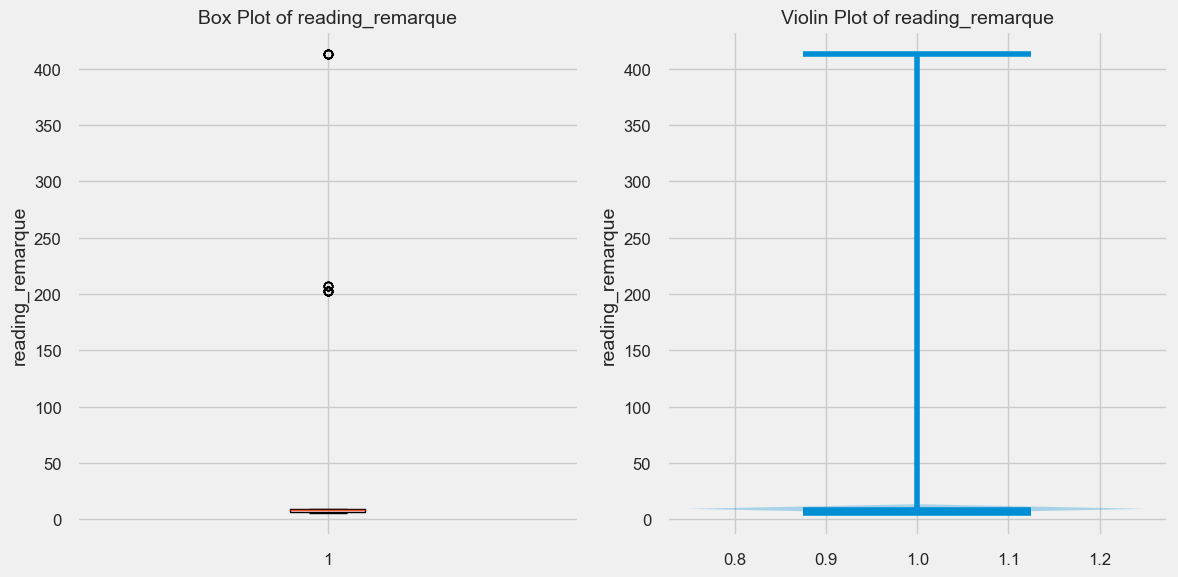

In [365]:
import matplotlib.ticker as ticker
def visualize_outliers(df, column_name):
    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Box plot
    axes[0].boxplot(df[column_name])
    axes[0].set_title(f'Box Plot of {column_name}')
    axes[0].set_ylabel(column_name)

    # Violin plot
    axes[1].violinplot(df[column_name], showmedians=True)
    axes[1].set_title(f'Violin Plot of {column_name}')
    axes[1].set_ylabel(column_name)

    # Format y-axis labels as regular numbers
    axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
    axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()


visualize_outliers(dfc, 'reading_remarque')
# Data have outliers, reading_remarque > 50

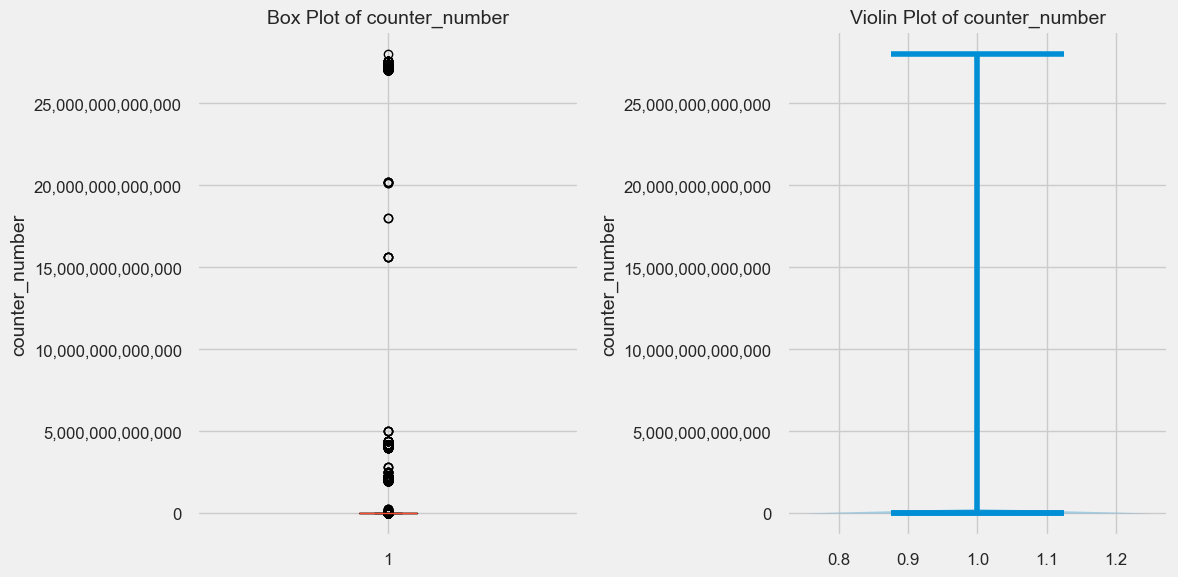

In [366]:
visualize_outliers(dfc, 'counter_number')
# Will probably drop above 10.000.000.000.000

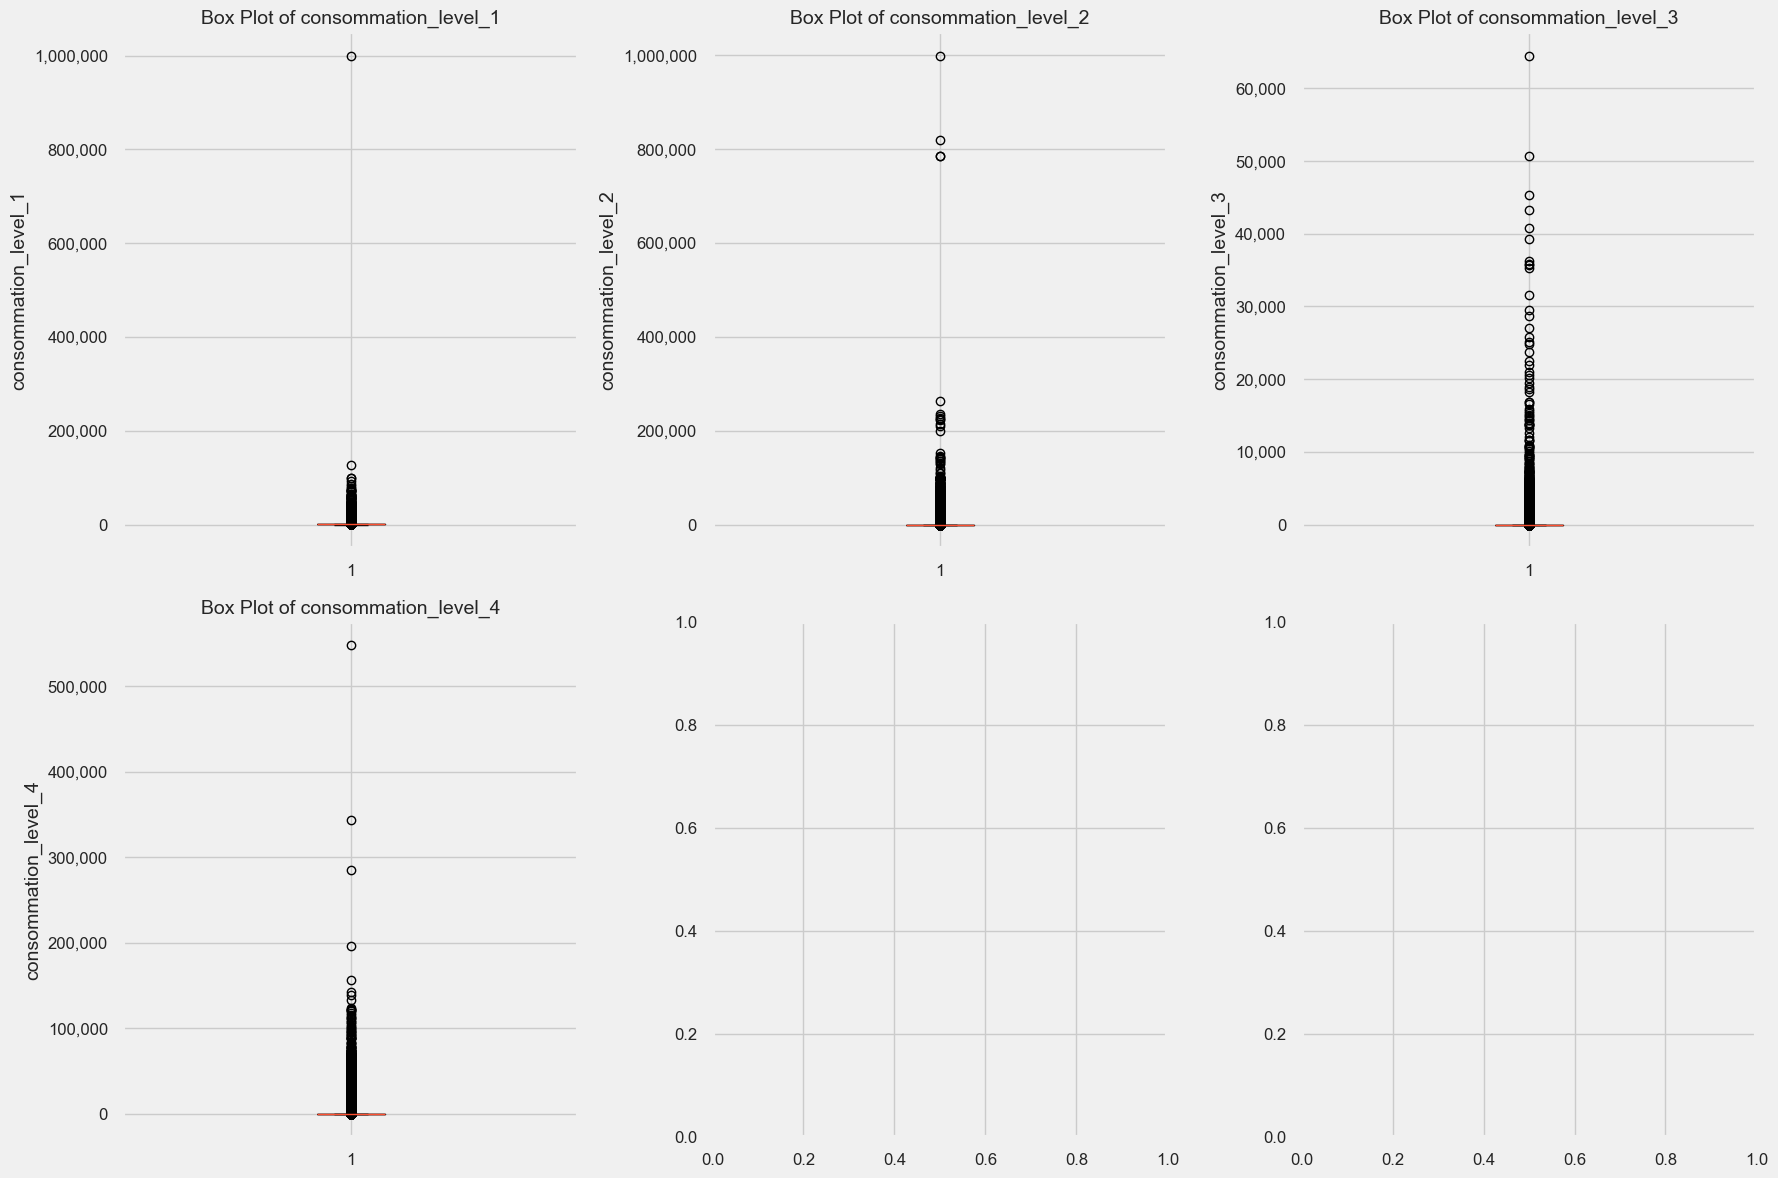

In [300]:
import matplotlib.ticker as ticker

def visualize_outliers_mult(df, column_names):
    num_columns = len(column_names)
    num_rows = (num_columns - 1) // 3 + 1
    num_cols = min(num_columns, 3)

    # Create subplots based on the number of columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 6*num_rows))

    # Iterate over the columns and create plots
    for i, column_name in enumerate(column_names):
        # Calculate the current row and column index
        row_index = i // 3
        col_index = i % 3

        # Determine the current axis for the plot
        if num_rows > 1:
            ax = axes[row_index, col_index]
        else:
            ax = axes[col_index]

        # Box plot
        ax.boxplot(df[column_name])
        ax.set_title(f'Box Plot of {column_name}')
        ax.set_ylabel(column_name)

        # Format y-axis labels as regular numbers
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

    # Remove empty subplots if any
    if num_columns < 3:
        for i in range(num_columns, 3):
            fig.delaxes(axes[row_index, i])

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()


visualize_outliers_mult(dfc, conso_cols)

In [340]:
print(len(dfc[dfc['consommation_level_1'] > 1000]) / len(dfc) * 100)
print(len(dfc[dfc['consommation_level_2'] > 10]) / len(dfc) * 100)
print(len(dfc[dfc['consommation_level_3'] > 10]) / len(dfc) * 100)
print(len(dfc[dfc['consommation_level_4'] > 10]) / len(dfc) * 100)

8.40525122136622
14.525942821453693
4.04764707603665
2.062724535148162


In [346]:
dfc_no_conso_outliers = dfc[(dfc['consommation_level_1'] < 1000) & (dfc['consommation_level_2'] < 10) & (dfc['consommation_level_3'] < 10) & (dfc['consommation_level_4'] < 10)]
print('Rows after removing outliers:', len(dfc_no_conso_outliers))
print(len(dfc_no_conso_outliers) / len(dfc) * 100, '%')

Rows after removing outliers: 3631960
81.12940886344086 %


## Combining client and invoice dataset

In [3]:
dfc = pd.merge(df_client, df_invoice, on='client_id')

In [35]:
dfc.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,31/12/1994,0.000,2014-03-24,11,1335667,0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,31/12/1994,0.000,2013-03-29,11,1335667,0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,31/12/1994,0.000,2015-03-23,11,1335667,0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,31/12/1994,0.000,2015-07-13,11,1335667,0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,31/12/1994,0.000,2016-11-17,11,1335667,0,...,9,1,572,0,0,0,15066,15638,12,ELEC


In [36]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   disrict               int64  
 1   client_id             object 
 2   client_catg           int64  
 3   region                int64  
 4   creation_date         object 
 5   target                float64
 6   invoice_date          object 
 7   tarif_type            int64  
 8   counter_number        int64  
 9   counter_statue        object 
 10  counter_code          int64  
 11  reading_remarque      int64  
 12  counter_coefficient   int64  
 13  consommation_level_1  int64  
 14  consommation_level_2  int64  
 15  consommation_level_3  int64  
 16  consommation_level_4  int64  
 17  old_index             int64  
 18  new_index             int64  
 19  months_number         int64  
 20  counter_type          object 
dtypes: float64(1), int64(15), object(5)
memory usage: 717.3+ MB


In [37]:
dfc.describe()

,disrict,client_catg,region,target,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000,4476749.000
mean,63.482,11.944,210.358,0.079,20.128,123058699065.183,172.488,7.322,1.003,410.979,109.322,20.306,52.926,17766.998,18349.705,44.831
std,3.273,6.022,103.583,0.270,13.473,1657267274261.927,133.887,1.572,0.308,757.308,1220.123,157.424,875.472,40366.926,40953.206,3128.335
min,60.000,11.000,101.000,0.000,8.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,62.000,11.000,103.000,0.000,11.000,121108.000,5.000,6.000,1.000,79.000,0.000,0.000,0.000,1791.000,2056.000,4.000
50%,62.000,11.000,301.000,0.000,11.000,494561.000,203.000,8.000,1.000,274.000,0.000,0.000,0.000,7690.000,8192.000,4.000
75%,63.000,11.000,309.000,0.000,40.000,1115161.000,207.000,9.000,1.000,600.000,0.000,0.000,0.000,21660.000,22343.000,4.000
max,69.000,51.000,399.000,1.000,45.000,27981145458733.000,600.000,413.000,50.000,999910.000,999073.000,64492.000,547946.000,2800280.000,2870972.000,636624.000


In [38]:
def plot_categorical_numerical(df, categorical_column, numerical_column):
    sns.violinplot(x=categorical_column, y=numerical_column, data=df)
    plt.xlabel(categorical_column)
    plt.ylabel(numerical_column)
    plt.title(f"{categorical_column} vs {numerical_column}")
    plt.show()

In [39]:
dfc['total_consommation'] = dfc['consommation_level_1'] + dfc['consommation_level_2'] +  dfc['consommation_level_3'] +  dfc['consommation_level_4']
def check_same_month(row):
    if row['creation_date'].month == row['months_number']:
        return 1
    else:
        return 0
dfc['creation_date'] = pd.to_datetime(dfc['creation_date'])
dfc['same_month'] = dfc.apply(check_same_month, axis=1)

In [40]:
univariate_categorical('same_month')

NameError: name 'univariate_categorical' is not defined

### Inferences:
There maybe little to no correlation between having the same month, but there are some outliers in months_number

In [ ]:
dfc['target'] = dfc['target'].astype('bool')
conso_cols = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']

In [ ]:

def create_correlation_table(df, int_columns, target_column):
    # Filter the relevant columns
    columns_to_keep = int_columns + [target_column]
    filtered_df = df[columns_to_keep]
    
    # Convert the target column to numeric
    filtered_df[target_column] = filtered_df[target_column].astype(int)
    
    # Calculate the correlation matrix
    correlation_matrix = filtered_df.corr()
    
    # Remove self-correlation and sort by absolute correlation value
    correlation_table = correlation_matrix.loc[int_columns, target_column].sort_values(ascending=False)
    
    return correlation_table
create_correlation_table(dfc, conso_cols+['total_consommation'], 'target')

consommation_level_3   0.024
total_consommation     0.017
consommation_level_4   0.013
consommation_level_2   0.008
consommation_level_1   0.006
Name: target, dtype: float64

### Inferences:
There are almost no correlation between consommation columns and target.

In [ ]:
dfc['counter_code'] = dfc['counter_code'].astype('category')
counter_cols = ['counter_number', 'counter_code', 'reading_remarque', 'counter_coefficient', 'counter_type']
counter_cat = ['counter_code', 'counter_type']
counter_num = ['counter_number', 'reading_remarque', 'counter_coefficient']

def create_numerical_correlation_table(df, numerical_columns, target_column):
    # Filter the relevant columns
    columns_to_keep = numerical_columns + [target_column]
    filtered_df = df[columns_to_keep]

    # Calculate the correlation matrix
    correlation_matrix = filtered_df.corr()

    # Extract the correlation values between numerical columns and the target column
    correlation_table = correlation_matrix[numerical_columns].loc[target_column].sort_values(ascending=False)

    return correlation_table

def create_categorical_correlation_table(df, categorical_columns, target_column):
    # Filter the relevant columns
    columns_to_keep = categorical_columns + [target_column]
    filtered_df = df[columns_to_keep]

    # Convert categorical columns to numeric using label encoding
    encoded_df = filtered_df.copy()
    for col in categorical_columns:
        encoded_df[col] = pd.factorize(encoded_df[col])[0]

    # Calculate the correlation matrix
    correlation_matrix = encoded_df.corr()

    # Extract the correlation values between categorical columns and the target column
    correlation_table = correlation_matrix[categorical_columns].loc[target_column].sort_values(ascending=False)

    return correlation_table

In [ ]:
create_numerical_correlation_table(dfc, counter_num, 'target')

counter_number         0.028
reading_remarque       0.005
counter_coefficient   -0.003
Name: target, dtype: float64

In [ ]:
create_categorical_correlation_table(dfc, counter_cat, 'target')

counter_code   0.032
counter_type   0.012
Name: target, dtype: float64

### Inferences:
There is also almost no correlation between counter columns with target.

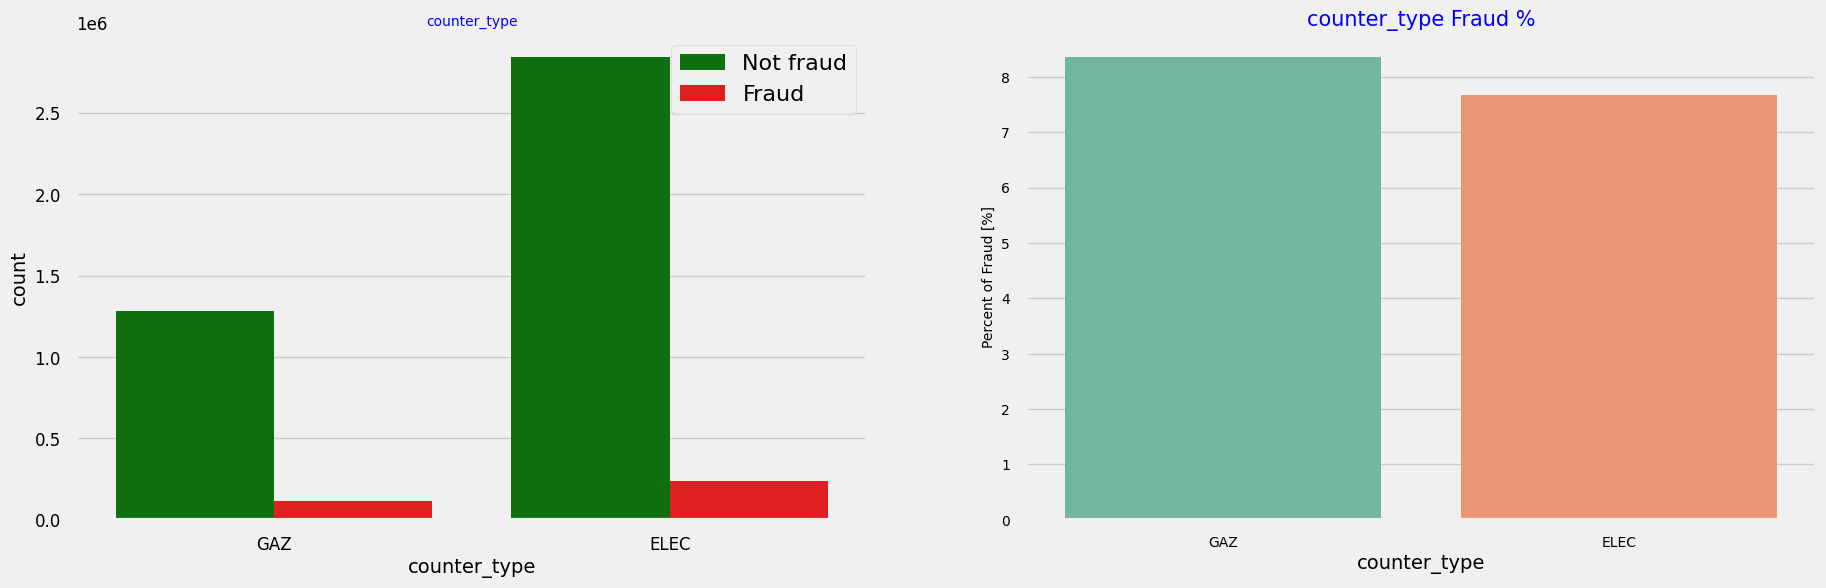

In [ ]:
univariate_categorical('counter_type')

### Inferences:
Client prefer counter_type ELEC rather than GAZ. Other than that, the different between fraud percentage is small

In [ ]:
create_categorical_correlation_table(dfc, ['region', 'client_catg'], 'target')

client_catg   0.066
region        0.040
Name: target, dtype: float64

In [ ]:
dfc.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,total_consommation,same_month
0,60,train_Client_0,11,101,1994-12-31,False,2014-03-24,11,1335667,0,...,82,0,0,0,14302,14384,4,ELEC,82,0
1,60,train_Client_0,11,101,1994-12-31,False,2013-03-29,11,1335667,0,...,1200,184,0,0,12294,13678,4,ELEC,1384,0
2,60,train_Client_0,11,101,1994-12-31,False,2015-03-23,11,1335667,0,...,123,0,0,0,14624,14747,4,ELEC,123,0
3,60,train_Client_0,11,101,1994-12-31,False,2015-07-13,11,1335667,0,...,102,0,0,0,14747,14849,4,ELEC,102,0
4,60,train_Client_0,11,101,1994-12-31,False,2016-11-17,11,1335667,0,...,572,0,0,0,15066,15638,12,ELEC,572,1


In [ ]:
dfc.counter_statue.unique()

array([0, 1, 5, 4, 3, 2, 769, '0', '5', '1', '4', 'A', 618, 269375, 46,
       420], dtype=object)

In [ ]:
mask = dfc['counter_statue'].isin(list(range(6)) + ['0', '1', '2', '3', '4', '5'])
dfc = dfc[mask]

In [ ]:
dfc.counter_statue.unique()

array([0, 1, 5, 4, 3, 2, '0', '5', '1', '4'], dtype=object)

In [ ]:
dfc['counter_statue'] = pd.to_numeric(dfc['counter_statue'], errors='coerce')
dfc['counter_statue'] = dfc['counter_statue'].astype('category')

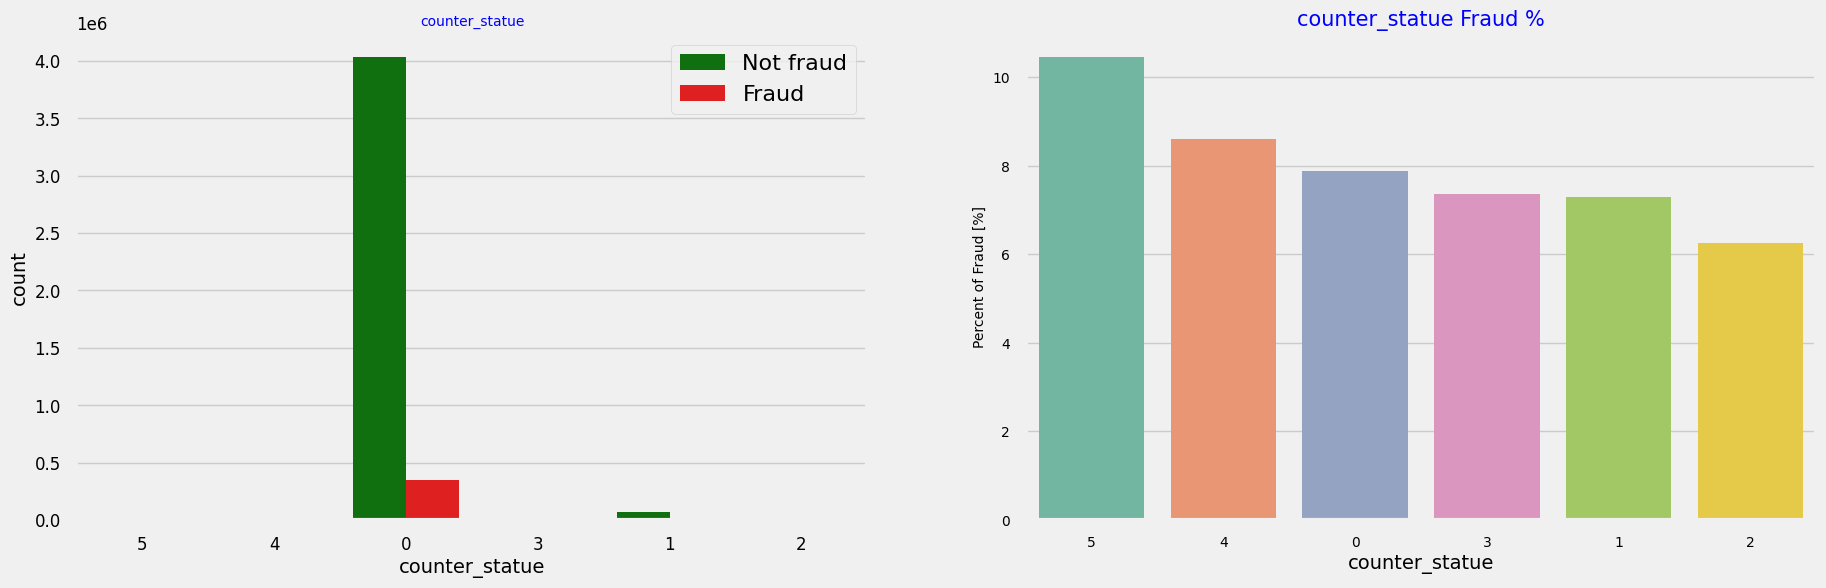

In [ ]:
univariate_categorical('counter_statue')

### Inferences:
The majority of client use counter_statue 0, and surprisingly, it doesnt have the most percentage of fraud.

In [133]:
def bin_data(column, num_bins, df=dfc):
    # Create bins
    edge, bins = pd.qcut(df[column], q=num_bins, retbins=True)
    # labels = [str(interval) for interval in bins.categories]

    # Assign labels to each bin
    labels = []
    for x in range(1, len(bins)):
        labels.append(f'{bins[x-1]} - {bins[x]}')

    # # Create the new categorical column based on the bin labels
    return pd.qcut(df[column], q=num_bins, labels=labels)

In [134]:
dfc['counter_number'].describe()

count          4476749.000
mean      123058699065.183
std      1657267274261.927
min                  0.000
25%             121108.000
50%             494561.000
75%            1115161.000
max     27981145458733.000
Name: counter_number, dtype: float64

In [176]:
dfc['bin_counter_number'] = bin_data('counter_number', 10)

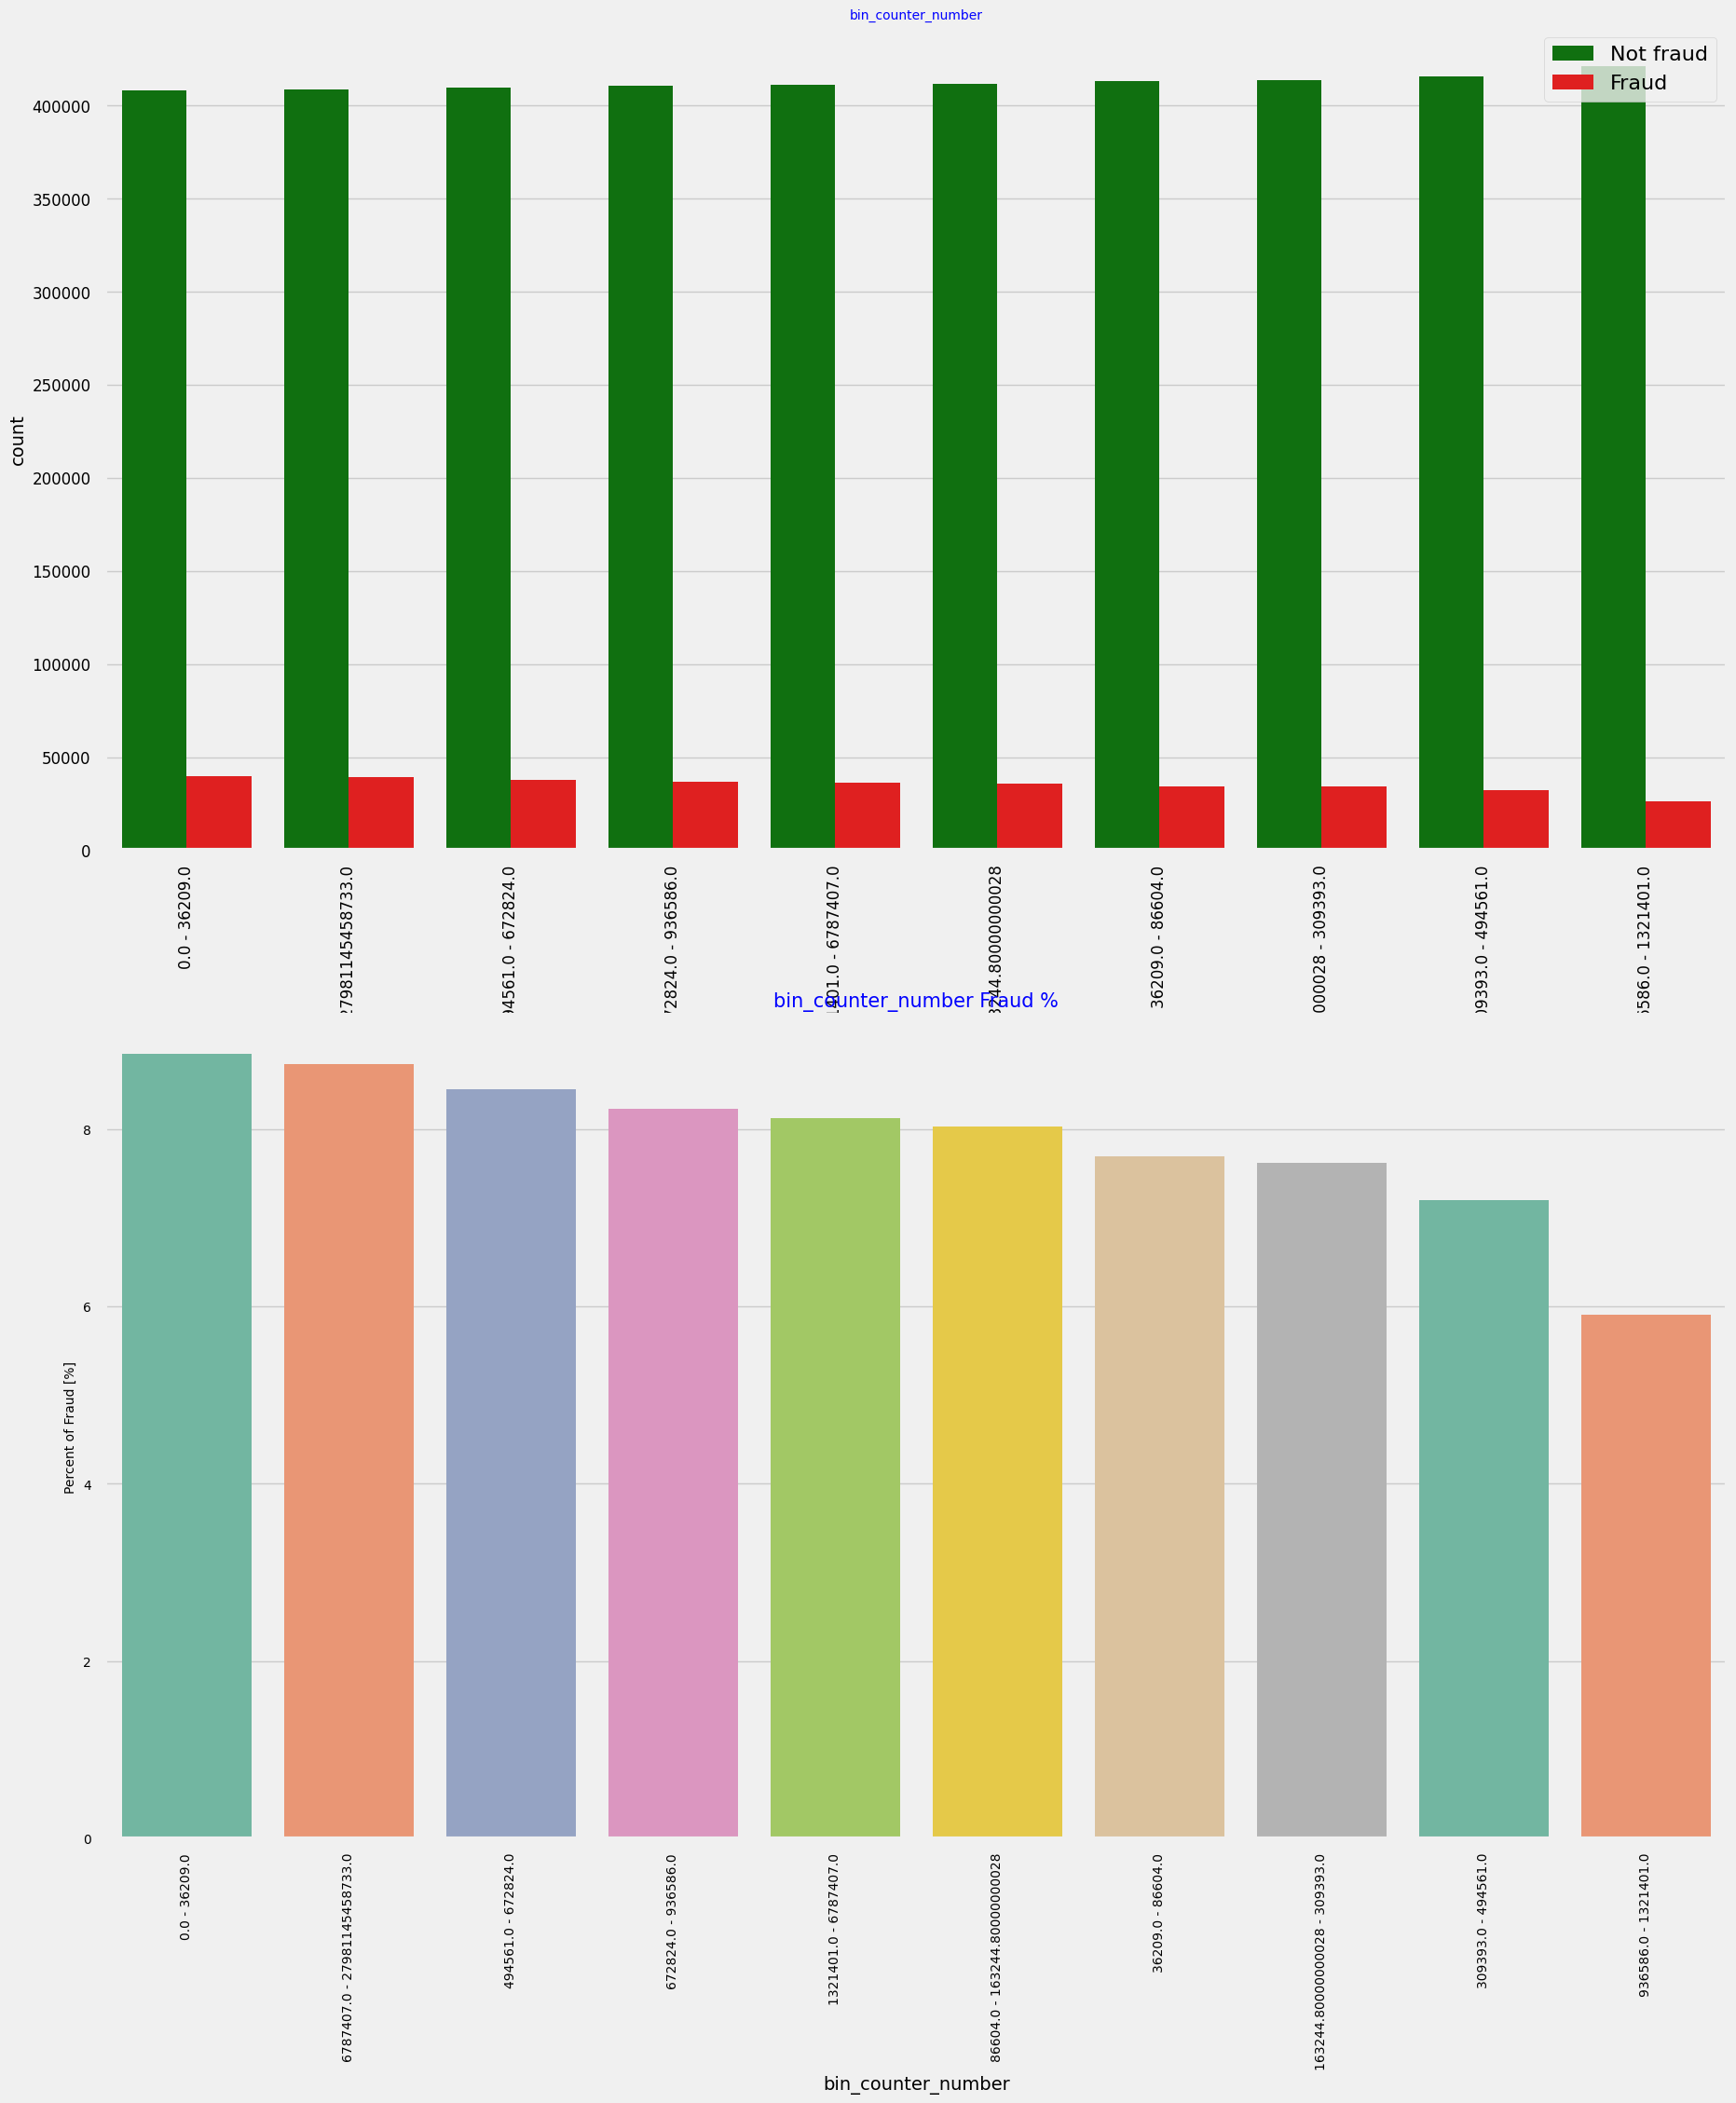

In [177]:
univariate_categorical('bin_counter_number', label_rotation=True, horizontal_layout=False)

### Inferences:
The highest fraud percentages occurs at the either end of counter_number.

In [137]:
dfc['consommation_level_1'].describe()

count   4476749.000
mean        410.979
std         757.308
min           0.000
25%          79.000
50%         274.000
75%         600.000
max      999910.000
Name: consommation_level_1, dtype: float64

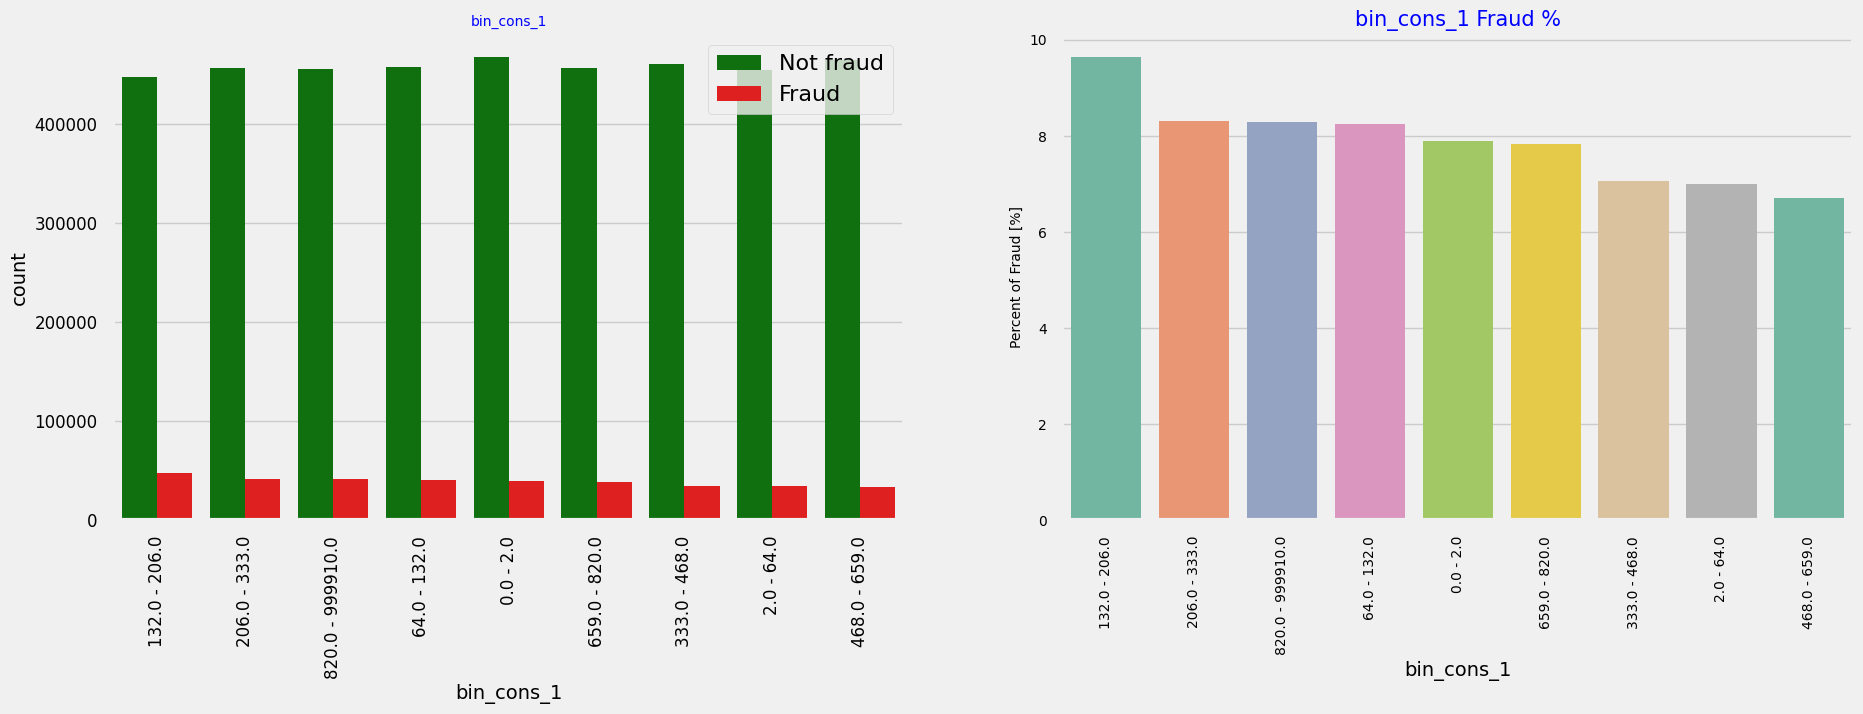

In [144]:
dfc['bin_cons_1'] = bin_data('consommation_level_1', 9)
univariate_categorical('bin_cons_1', label_rotation=True)

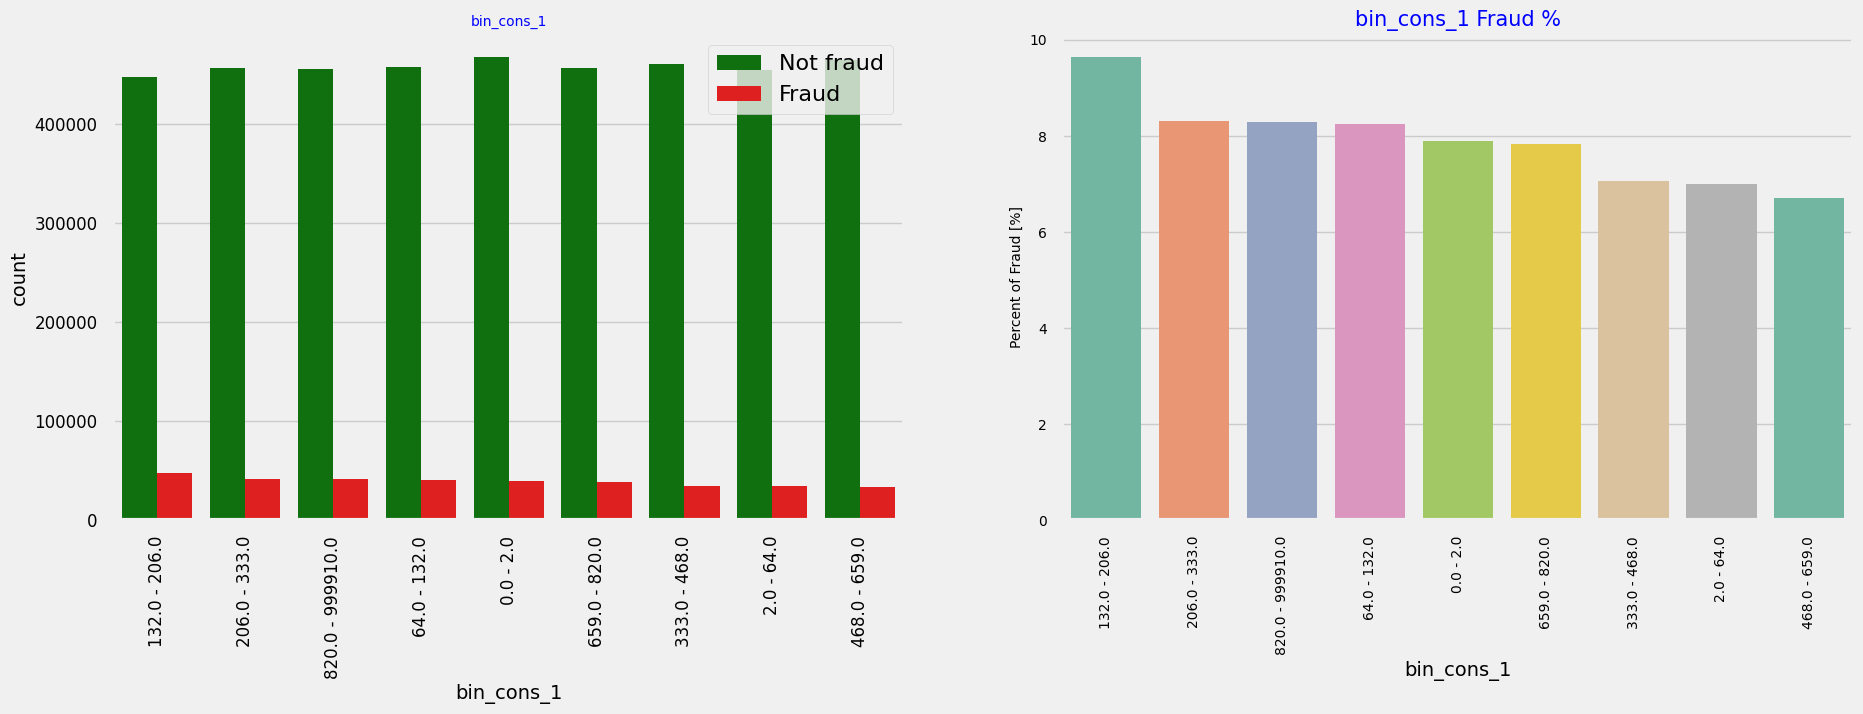

In [152]:
dfc['bin_cons_1'] = bin_data('consommation_level_1', 9)
univariate_categorical('bin_cons_1', label_rotation=True)

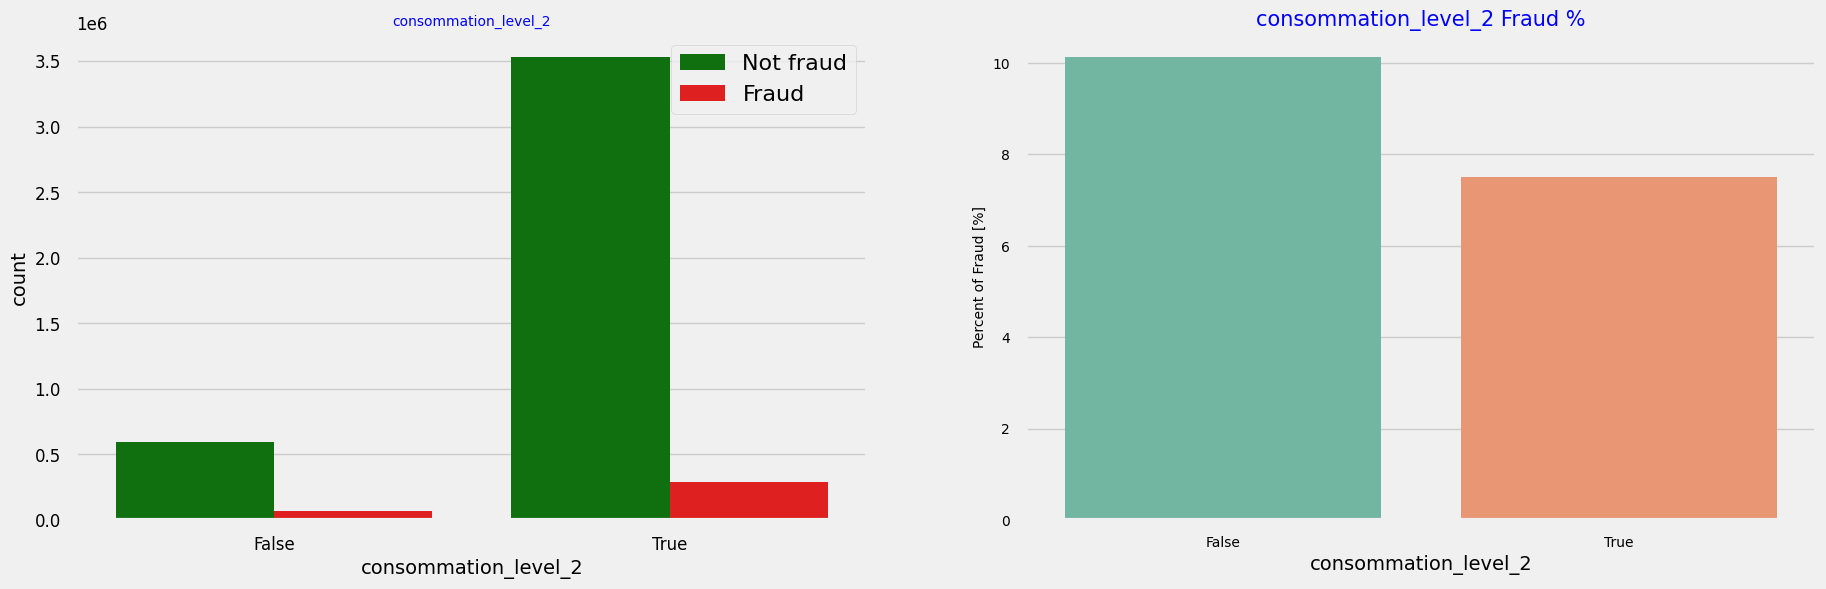

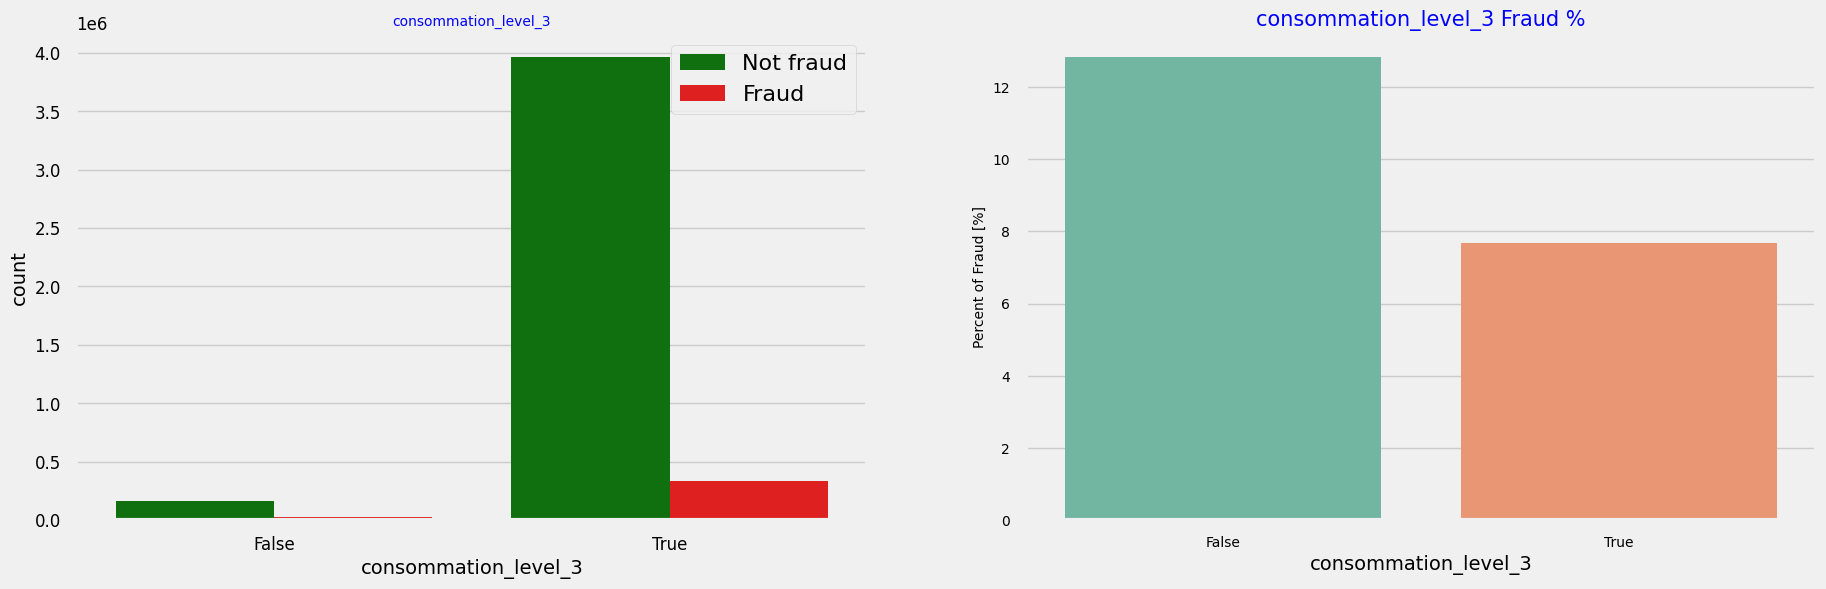

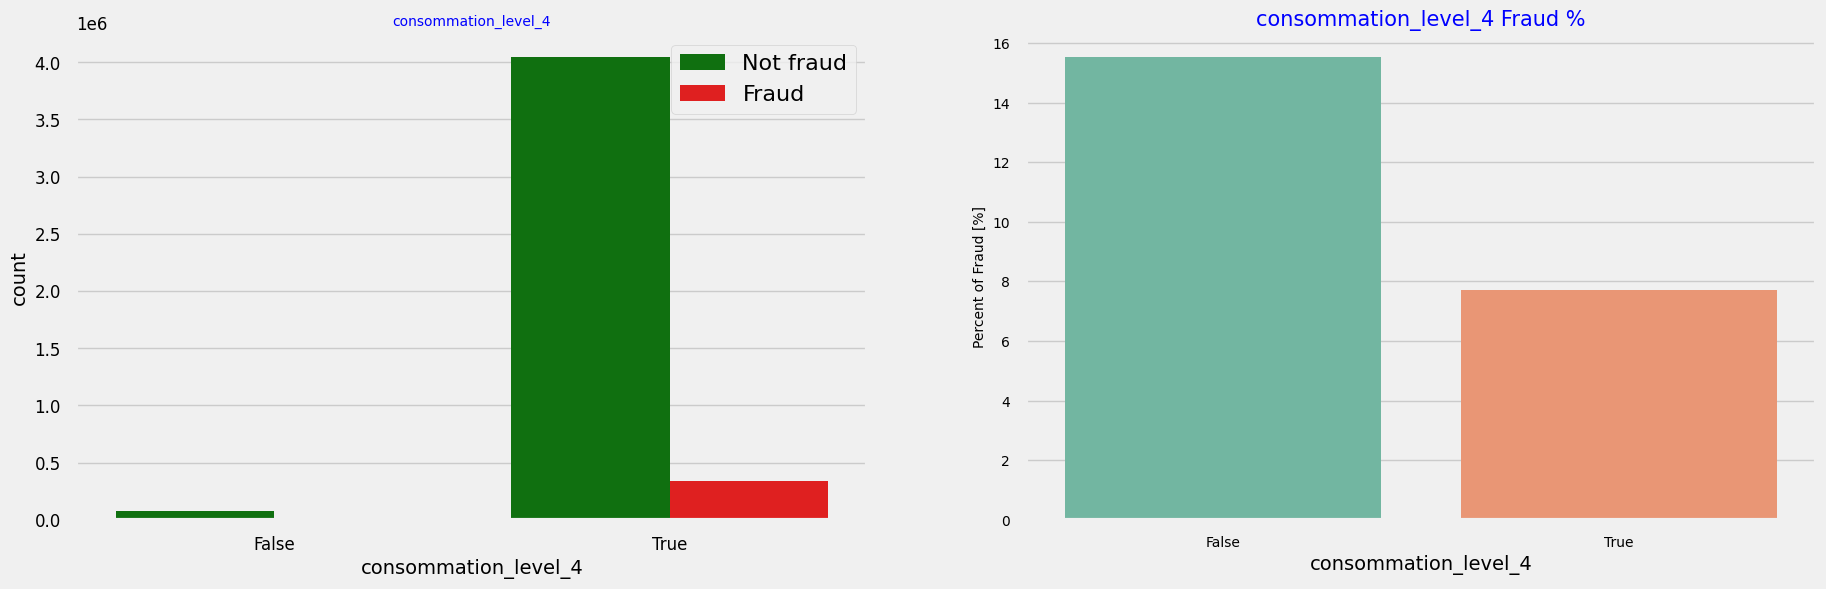

In [168]:
conso_cols = ['consommation_level_2', 'consommation_level_3', 'consommation_level_4']
for x in conso_cols:
    conso_df_temp = dfc.copy()
    conso_df_temp[x] = conso_df_temp[x].map(lambda x: True if x < 0 else False)
    univariate_categorical(x, conso_df_temp)


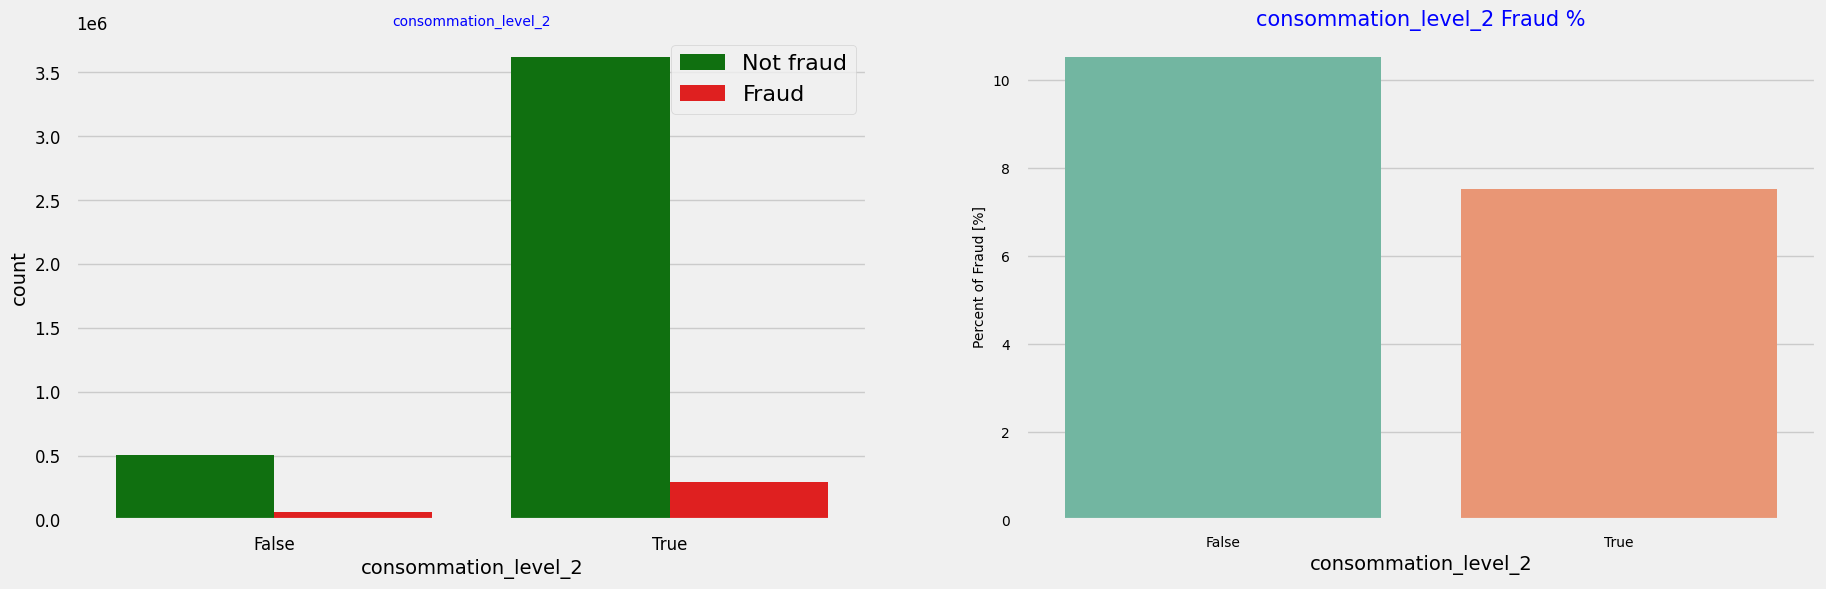

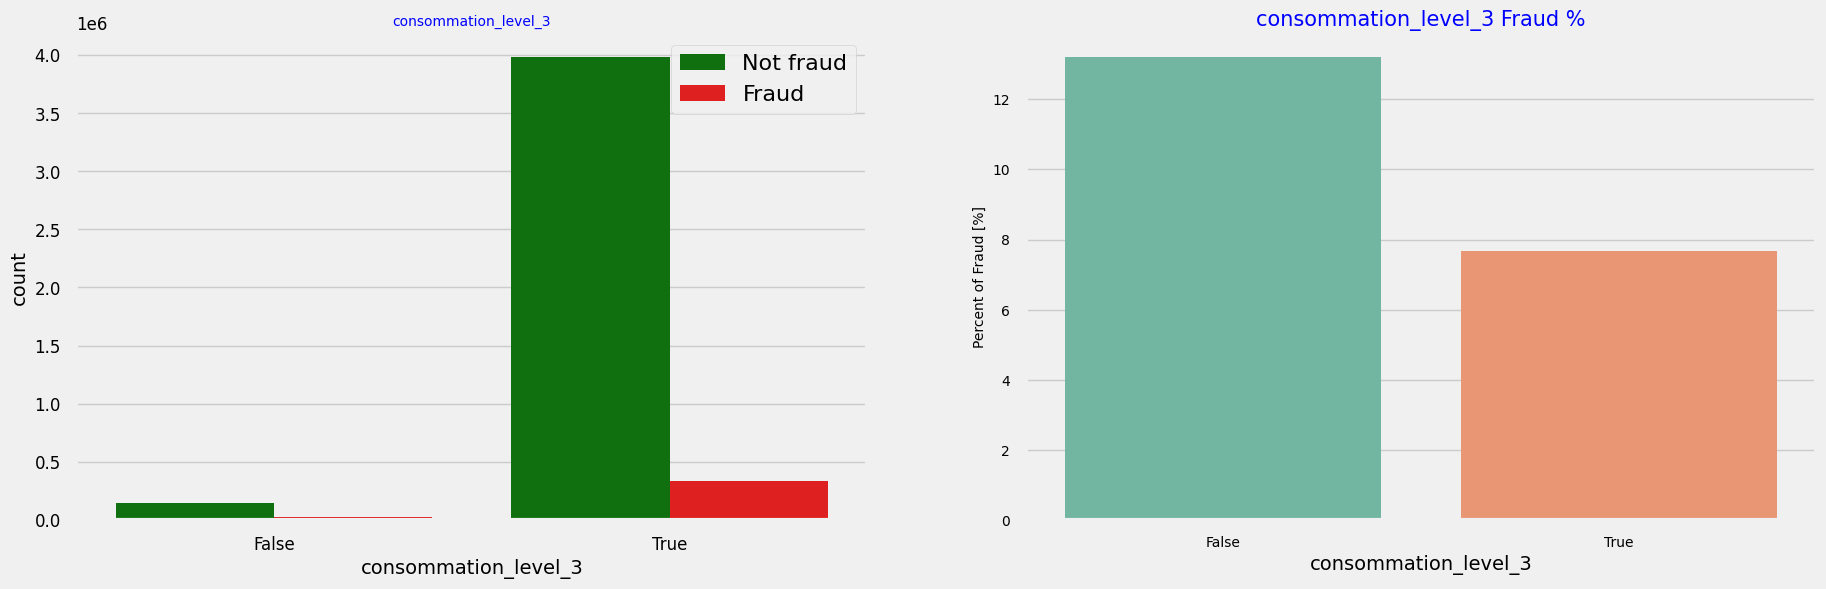

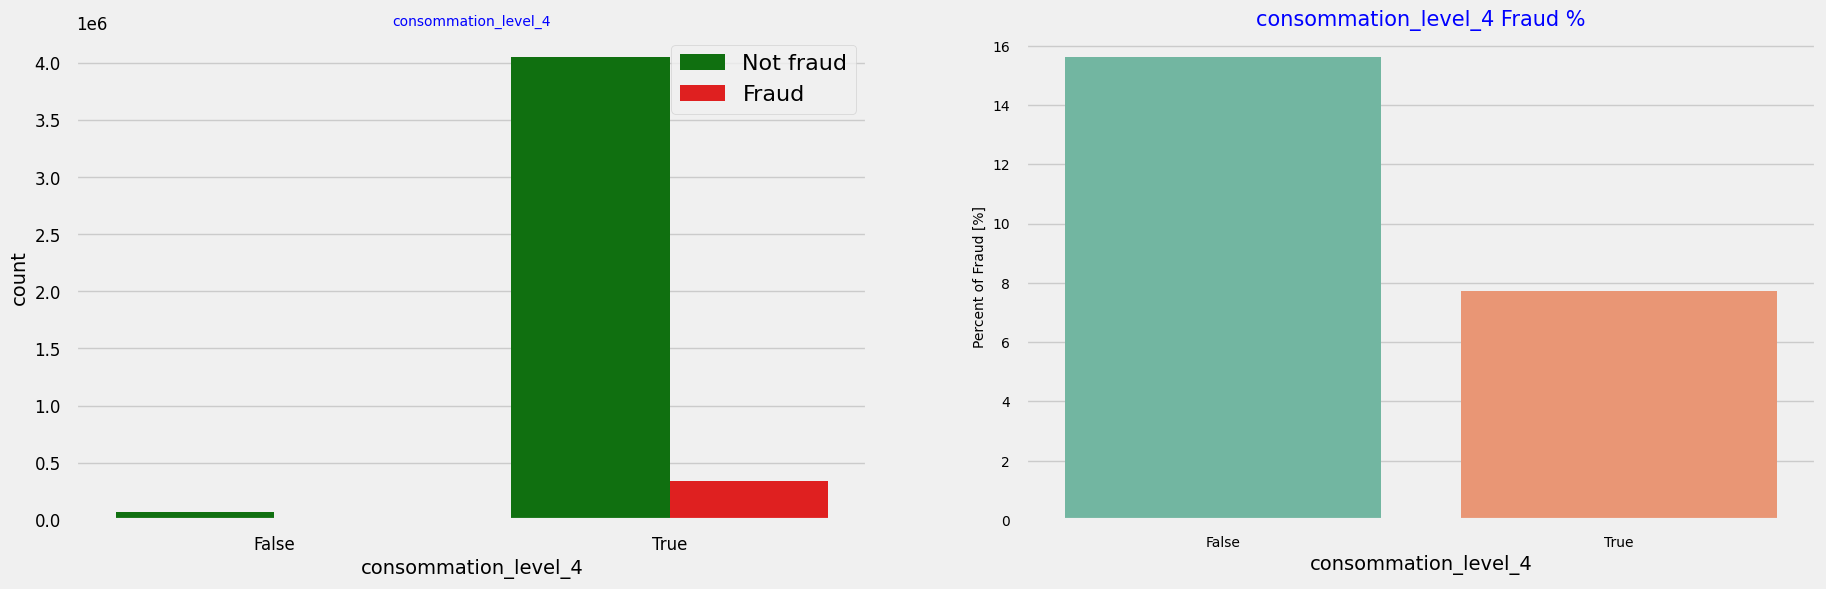

In [169]:
conso_cols = ['consommation_level_2', 'consommation_level_3', 'consommation_level_4']
for x in conso_cols:
    conso_df_temp = dfc.copy()
    conso_df_temp[x] = conso_df_temp[x].map(lambda x: True if x < 100 else False)
    univariate_categorical(x, conso_df_temp)


### Inferences:
- Client with 64-333 and above 820 *consommation_level_1* have a high percentage of fraud (>8%), especially 132-206 with almost 10% of fraud.
- Client with high consommation level 2 - 4, tends to fraud more, especially above 100.

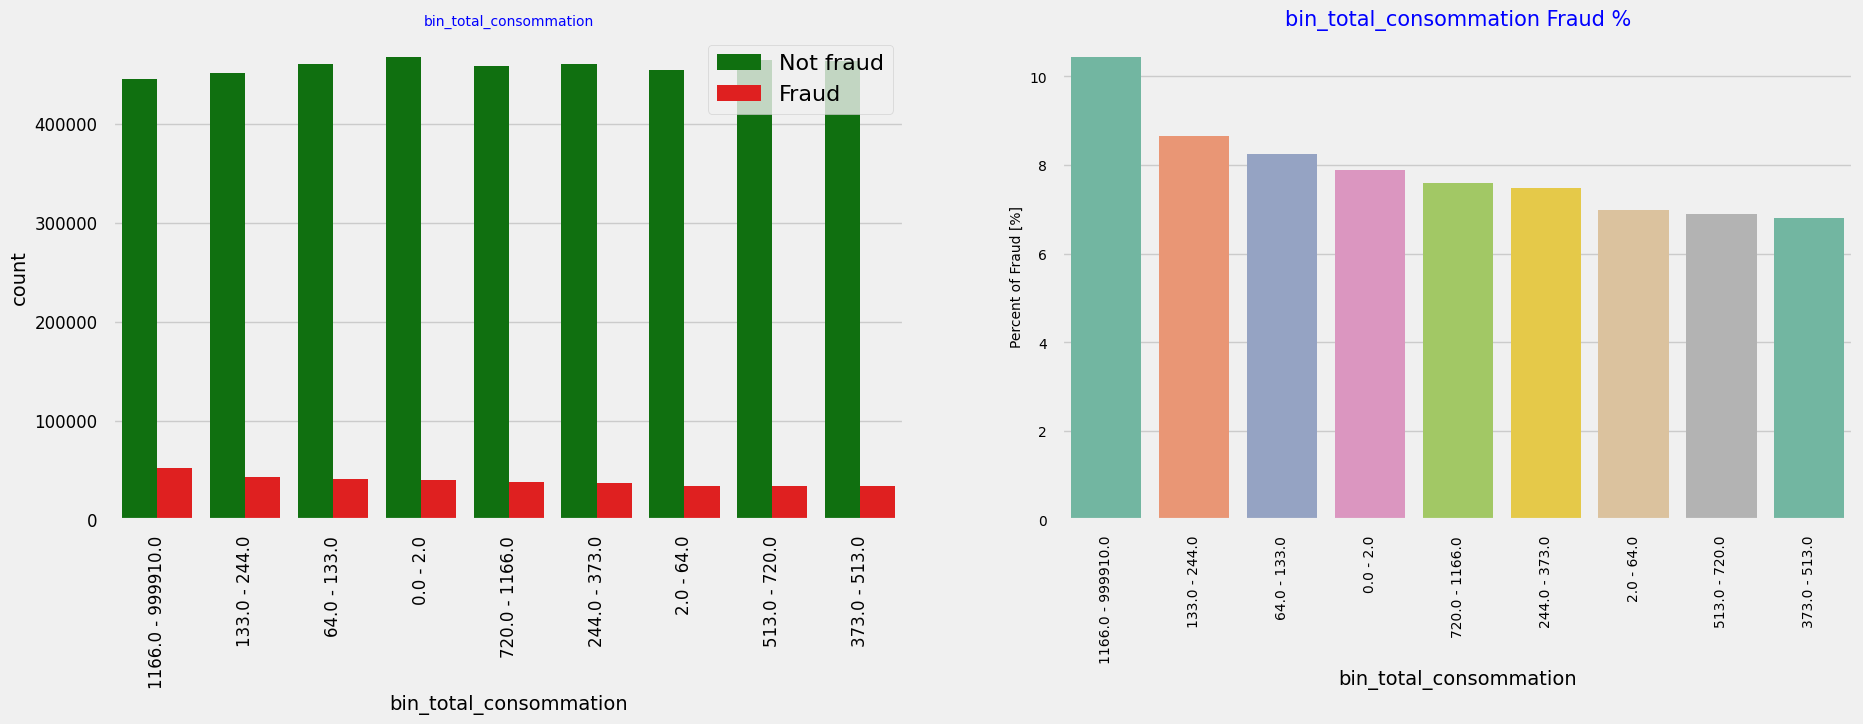

In [173]:
conso_cols = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4']
dfc['total_consommation'] = dfc[conso_cols].sum(axis=1)
dfc['bin_total_consommation'] = bin_data('total_consommation', 9)
univariate_categorical('bin_total_consommation', label_rotation=True)

### Inferences:
Client with high total consommation have a high rate (over 10%) of fraud.

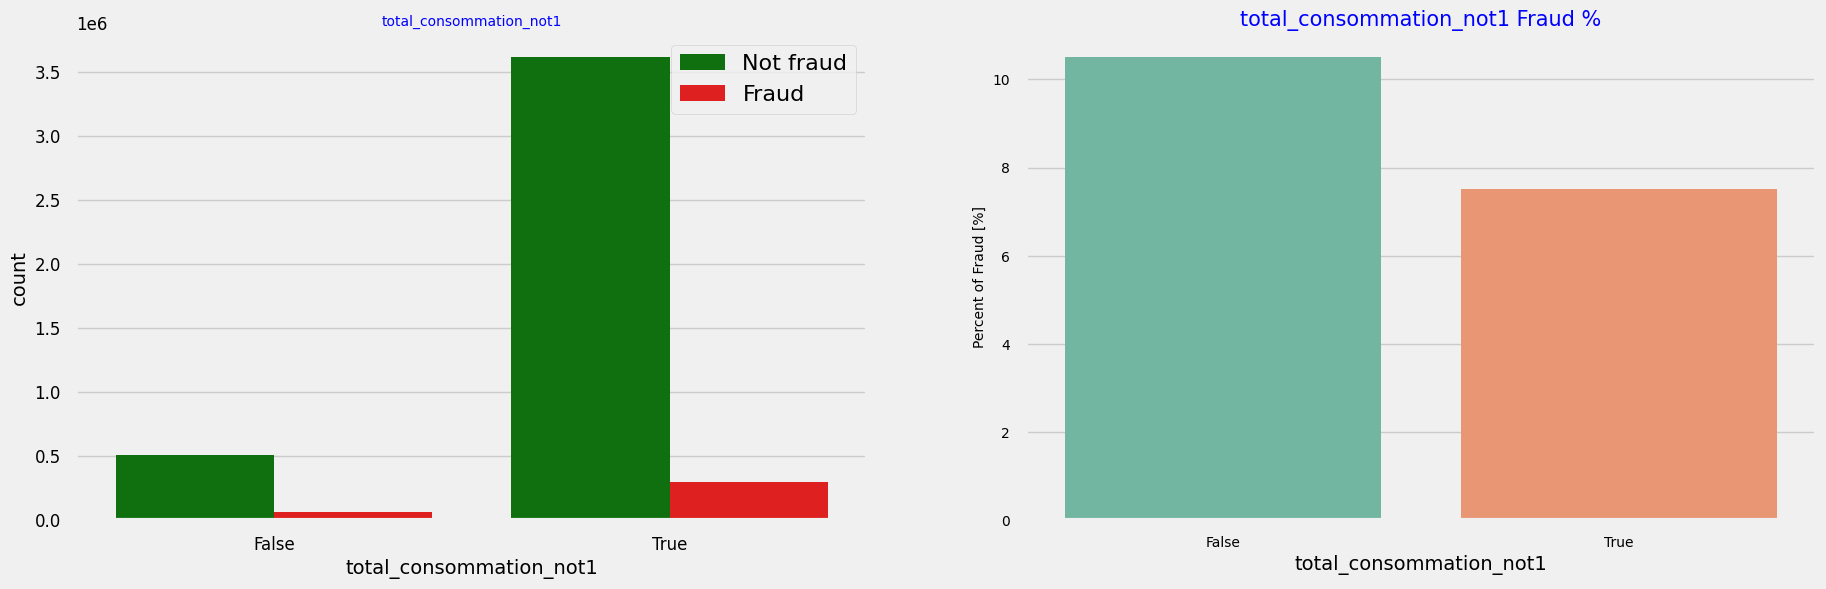

In [175]:
conso_cols_not1 = ['consommation_level_2', 'consommation_level_3', 'consommation_level_4']
conso_df_temp['total_consommation_not1'] = conso_df_temp[conso_cols_not1].sum(axis=1)
conso_df_temp['total_consommation_not1'] = conso_df_temp['total_consommation_not1'].map(lambda x: True if x < 100 else False)
univariate_categorical('total_consommation_not1', conso_df_temp)

### Conclusion
After analysing the datasets, there are few attributes of a client with which should be paying attention to.

#### Decisive Factor wether the transaction will be a fraud
1. *client_catg*: 51 have the highest percentage of being fraud, but also have the lowest record, so need more data on this.
2. *disrict*: 69 and 63 have the highest percentage of being fraud (over 7% and 6.5%), while 60 have the lowest (3.5%)
3. *region*: Based on data, region 103, 372, 311 are **not safe** from fraud, achieving more than 10% case of fraud.Region 101 and 301 are **safe**, considering they have a low percentage of fraud with high transactions. Region 199, 399, and 206 are safe, but they also have only some record of transactions, not as many as the others.
4. *counter_statue*: 5 have the highest value (>10%) even though it has really low transaction record.
5. *counter_number*: clients whose counter numbers are located at either end of the dataset are more likely to be associated with fraudulent activity.
6. *consommation_level*: Client with 64-333 and above 820 *consommation_level_1* have high percentages of fraud. Client with high consommation level 2-4 tends to fraud more. Client with high total consommation also have a high rate (over 10%) of fraud.
7. *consommation_level_4*: Client with consommation_level_4 more than 100 have a really high chance to fraud, please pay attention more to this variable.

### Suggestions
- Pay more attention to consommation_level variable
- Based on analysis, *consommation_level_4* is the key to check if its a fraud case.
- Do not accept transaction with low (< 36209) or high (> 6787407) counter_number, as based on data, client with that couter_number have high reate of fraud

### Note
There are too many outliers in the data, especially in the invoice dataset. It will be best to look into it in the future.